## Author: Ammar Waddah

# About Dataset
Context

This classic dataset contains the prices and other attributes of almost 54,000 diamonds, but in SHAI competition project we use a subset of the full data which contain only 43040 diamonds.

* Content price price in US dollars (\$326--\$18,823)

* carat weight of the diamond (0.2--5.01)

* cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* color diamond colour, from J (worst) to D (best)

* clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

* x length in mm (0--10.74)

* y width in mm (0--58.9)

* z depth in mm (0--31.8)

* depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

* table width of top of diamond relative to widest point (43--95)

# Importing Libraries

In [1]:
import numpy as np
from statistics import mode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, QuantileTransformer, PowerTransformer, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, TweedieRegressor, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from google.colab import files

# Loading Data

In [2]:
data=pd.read_csv("/content/train.csv")

# Take some information about the data before we get deeper into the analysis

#### Take a look about the basic information of the data

In [ ]:
# print first 5 rows of the data
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
1,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
2,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
3,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
4,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47


In [ ]:
# print last 5 rows of the data
data.tail()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
43035,53935,0.72,Premium,D,SI1,62.7,59.0,2757,5.69,5.73,3.58
43036,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
43037,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
43038,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
43039,53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


In [ ]:
# we will get brief info about the data element type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43040 entries, 0 to 43039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  43040 non-null  int64  
 1   carat       43040 non-null  float64
 2   cut         43040 non-null  object 
 3   color       43040 non-null  object 
 4   clarity     43040 non-null  object 
 5   depth       43040 non-null  float64
 6   table       43040 non-null  float64
 7   price       43040 non-null  int64  
 8   x           43040 non-null  float64
 9   y           43040 non-null  float64
 10  z           43040 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
# check categorical columns in the dataframe
data.select_dtypes(include=['object']).columns.tolist()

['cut', 'color', 'clarity']

In [ ]:
# check numerical columns in dataframe
data._get_numeric_data().columns

Index(['Unnamed: 0', 'carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')

In [ ]:
# show brief info about numerical columns of the data
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000
mean,26758.804554,0.796964,61.746080,57.439542,3942.706343,5.724376,5.728122,3.534367
std,15484.904515,0.481455,1.435246,2.240196,4023.534556,1.132496,1.159641,0.714543
min,2.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13326.750000,0.380000,61.000000,56.000000,940.000000,4.660000,4.670000,2.870000
50%,26824.500000,0.710000,61.800000,57.000000,2388.000000,5.710000,5.720000,3.530000
75%,40290.250000,1.030000,62.500000,59.000000,5309.250000,6.500000,6.500000,4.020000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


#### Check the probabilities of each categorical data

**Starting our statistics with categorical features**

In [ ]:
def unique_cat_count(data, series):
    '''
    Plot the count of each unique value in the series data frame.
    Args:
    data-- dataframe type describes the full dataset we need to deal with it.
    series-- list of strs type describes the feature we want to represent its unique values count.
    Returns:
    A plot that represents the total count of each unique category.
    '''
    plt.figure(figsize=(15,10))
    for index, element in enumerate(series):
      plt.subplot(np.ceil(len(series)/2), 2, index +1)
      plt.pie(data[element].value_counts(), labels= data[element].value_counts().index, autopct='%.0f%%')
      plt.subplots_adjust()
    return plt.show()

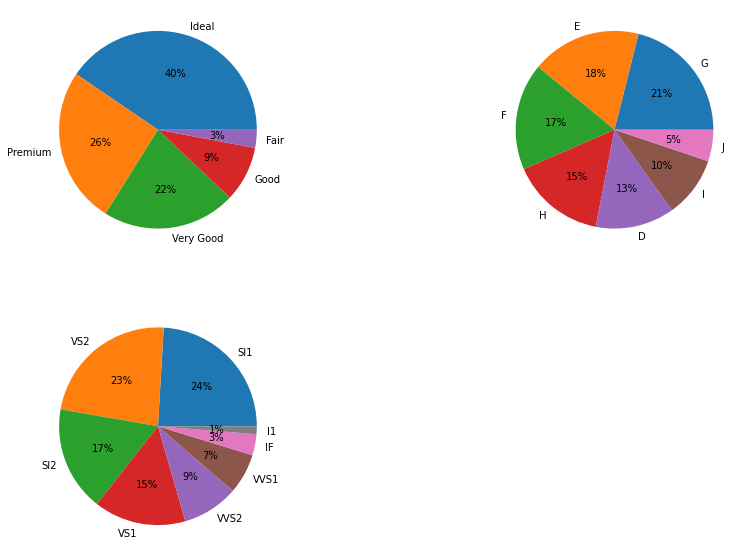

In [ ]:
# check 'cut' unique values count
unique_cat_count(data, ['cut', 'color', 'clarity'])

**Discussion Stage**\
From the plots of the categorical features count, I notice imbalance counts in the data, but I think it will not obviously affect the model

#### Check the ranges of each numerical feature

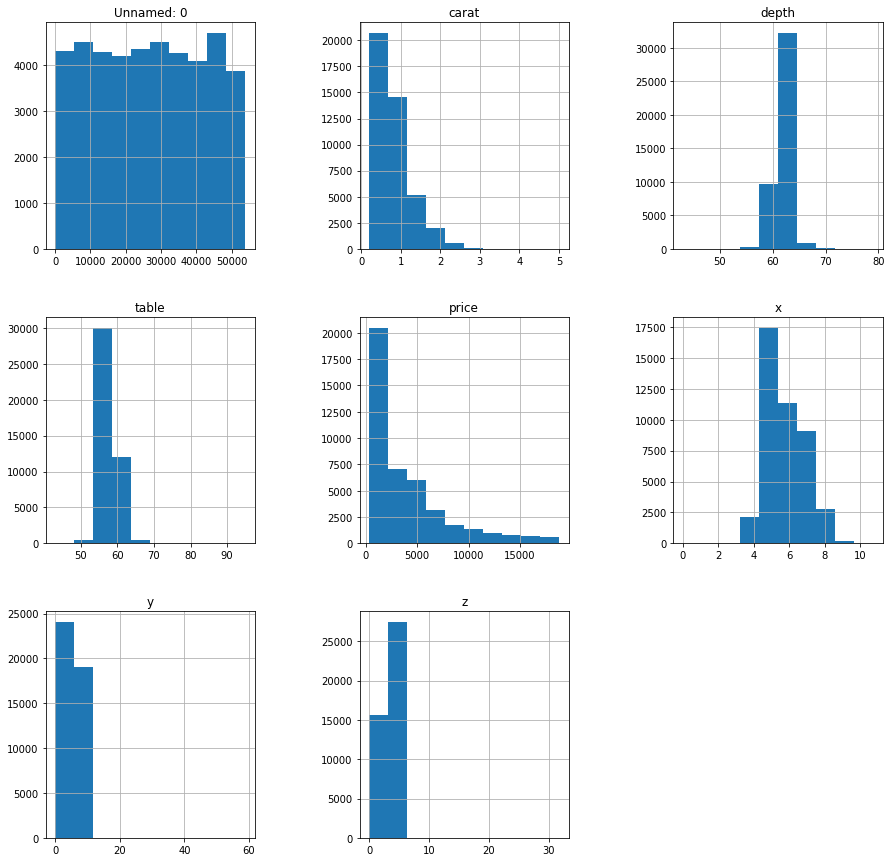

In [ ]:
# A histogram plot that represents the ranges of each feature and how many values between each bin
data.hist(figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

**Discussion Stage**\
All features follow a diffrent distribution, all skew left except x, y, z

#Going deeper into the analysis

#### Plot correlation line between features

In [ ]:
# ploting correlations line between data
def cor_lines(data, axes_data, target_axis):
    '''
    Print correlation line between all features in the dataframe
    Args:
    data-- dataframe type describes the full dataset we need to deal with it.
    axes_data-- list of axes.
    target_axis-- str describes the y axis
    Returns:
    A plots describs the correlations between features.
    '''
    # create the blank figure
    plt.figure(figsize=(15,10))
    for index, element in enumerate(axes_data):
      plt.subplot(np.ceil(len(axes_data)/2),2, index+1)
      # check if the axes are equivalent to ignore
      if element == target_axis:
        sns.histplot(data=data, x=element)
      else:
        sns.lineplot(x= element, y= target_axis, data= data)
        plt.title(f"{element} feature and {target_axis} target correlation")
        # set x and y labels
        plt.xlabel(element)
        plt.ylabel(target_axis)
    # adjust height space
    plt.subplots_adjust(wspace= 0.4, hspace = 0.8)
    return plt.show()

In [ ]:
# initialize features to get correlation lines between them
axes_data= data._get_numeric_data().columns.to_list()

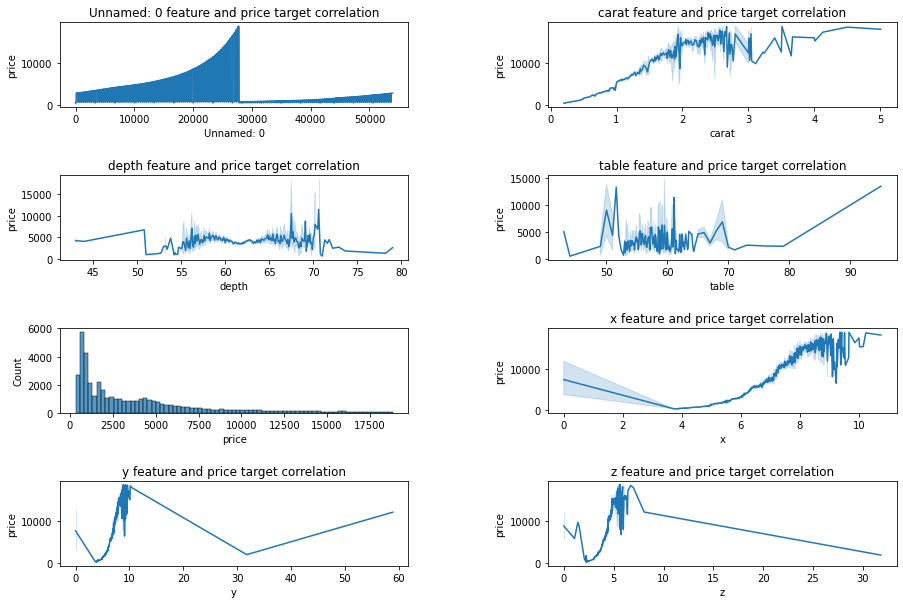

In [ ]:
# check the correlation between target and features
cor_lines(data, axes_data, 'price')

**Discussion Stage**\
There is a high correlation between:
* carat and price.
* (x, y, z) and price.

There is some correlation between:
* table and price.

There is a very low correlation between:
* depth and price.

There is no correlation between, it seems counted column:
* Unnamed: 0 and price.

So, we are dealing with multivariate linearity.

#### Plot pairplot

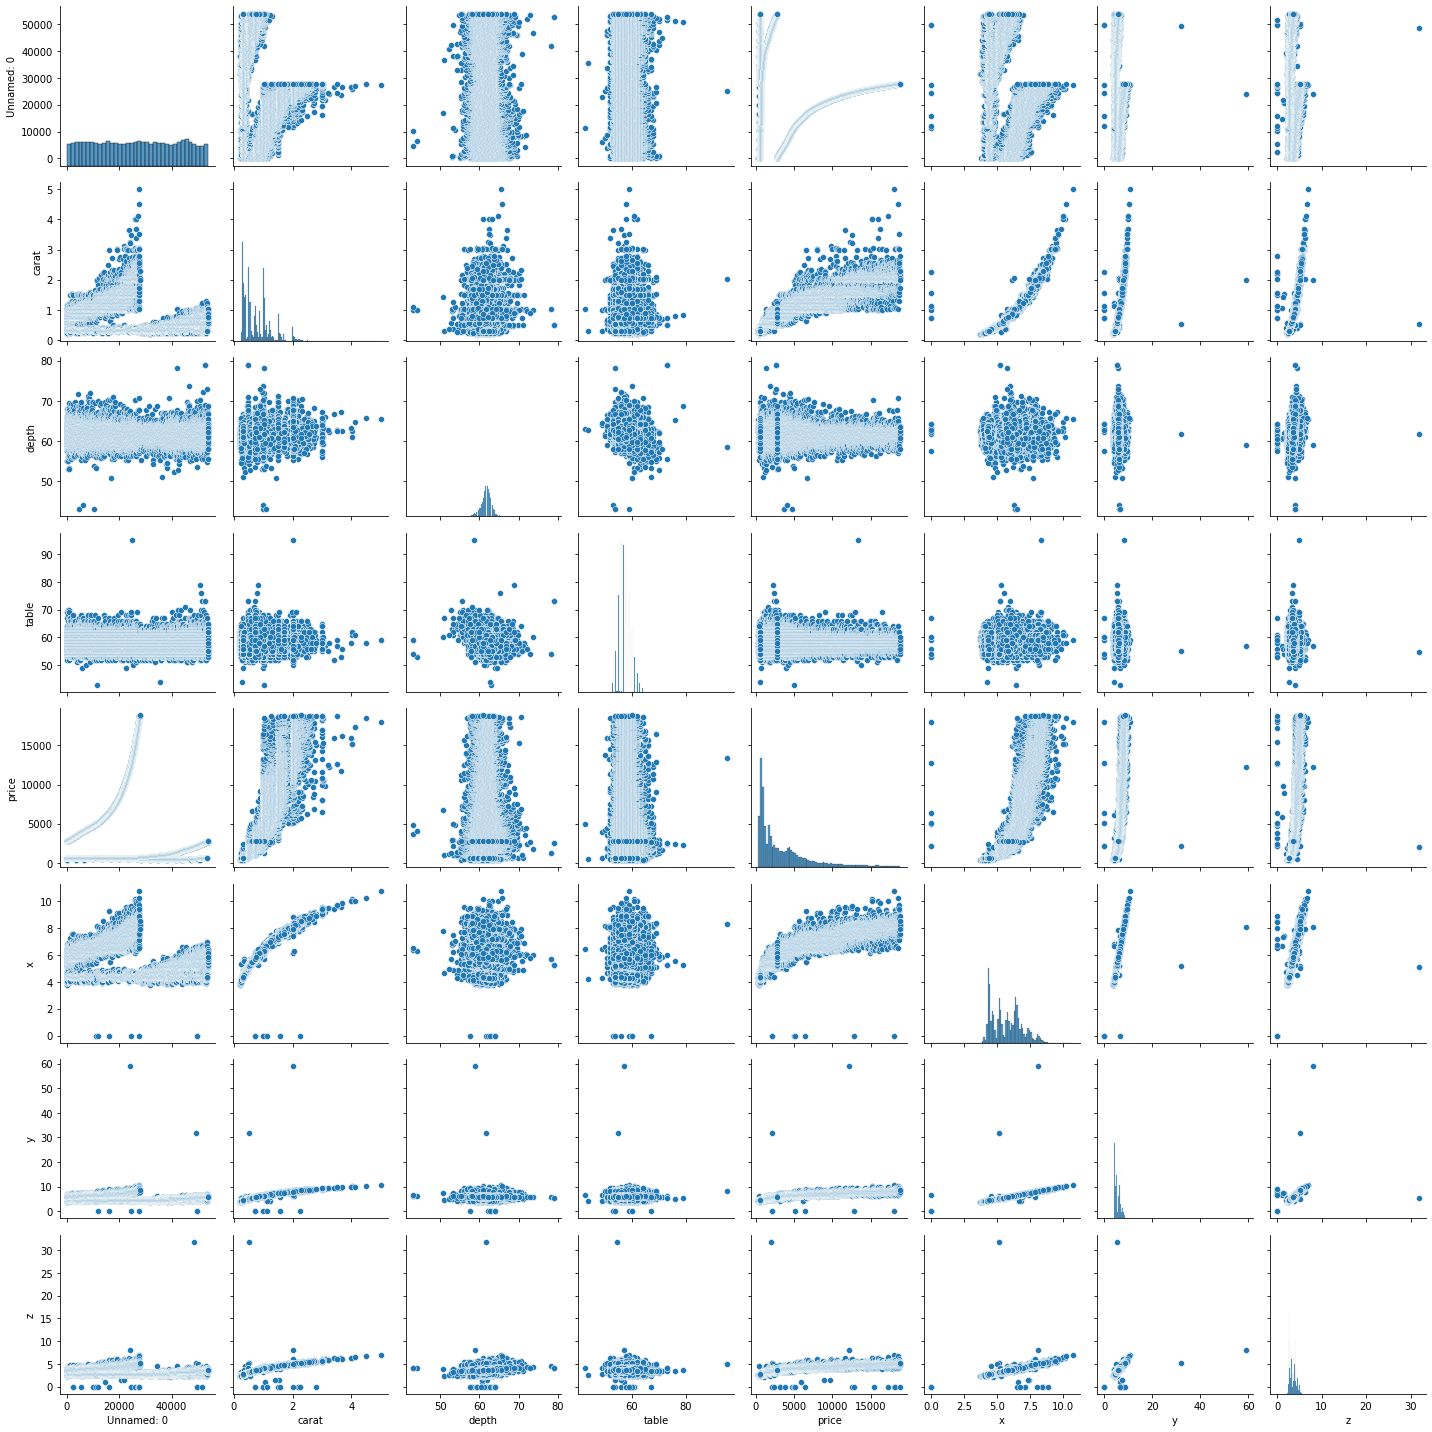

In [ ]:
# plotting pairplot correlations between data

sns.pairplot(data= data)

# adjust height space
plt.tight_layout()
plt.show()

**Discussion Stage**

There is a high correlation between:
* carat and x, y,and z, also there are clearly outliers in these features.

* There is diffrent distribution in all features except x, y, z.

#### Check correlation and outliers if it's exist

In [ ]:
# ploting correlations between data
def lm(data, axes_data, target_axis):
    '''
    Print correlation with line between all features data point in the dataframe
    Args:
    data-- dataframe type describes the full dataset we need to deal with it.
    axes_data-- list of axes.
    target_axis-- str describes the y axis
    Returns:
    A plots describs the correlations between features.
    '''
    # create the blank figure
    plt.figure(figsize=(15,10))
    for index, element in enumerate(axes_data):
      plt.subplot(np.ceil(len(axes_data)/2),2, index+1)
      # check if the axes are equivalent to ignore
      if element == target_axis:
        sns.histplot(data=data, x=element)
        plt.title(f"{element} feature count")
        # set x label
        plt.xlabel(target_axis)
      else:
        sns.regplot(x=target_axis, y=element, data=data, scatter_kws={"color": '#6EB8F0'}, line_kws={"color": "#BE344F"})
        plt.title(f"{element} feature and {target_axis} target data point")
        # set x and y labels
        plt.xlabel(target_axis)
        plt.ylabel(element)
    # adjust height space
    plt.subplots_adjust(wspace= 0.4, hspace = 0.8)
    return plt.show()

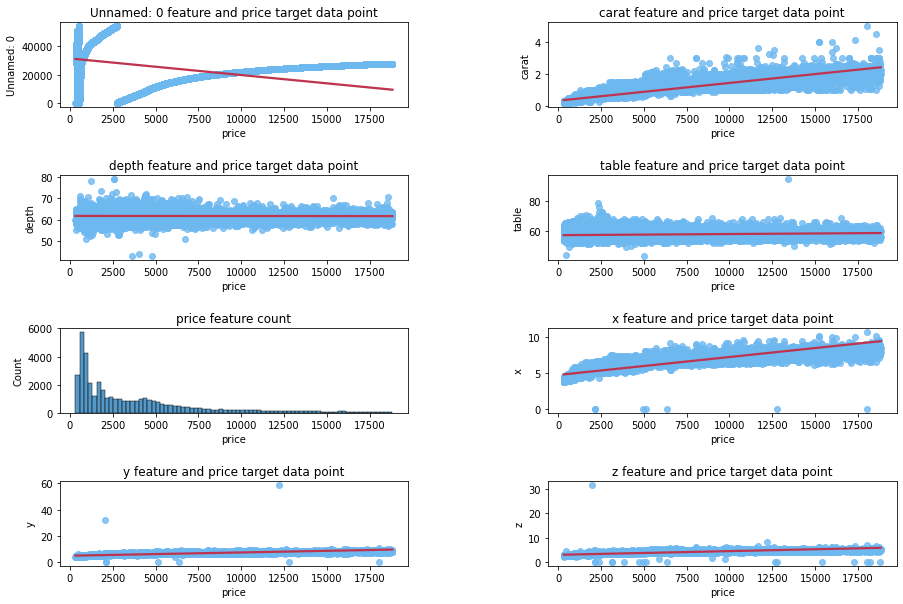

In [ ]:
# check categorical columns in the dataframe
# show how points variant in cut, clarity, colors features
axes_data= data._get_numeric_data().columns.to_list()
lm(data= data, axes_data= axes_data, target_axis= 'price')

#### Plot vio to check the effect of categorical features on the target

In [ ]:
def vio_categorical(x, y, data):
  '''
  visualize the correlation and how values variant in categorical data
  Args:
  x-- list of strs describe the x coordinate
  y-- str describe the y coordinate
  data-- dataframe describe the data we dealing with
  Returns:
  Plt visualize the correlation and how values variant with categorical data
  '''
  # create the blank figure
  plt.figure(figsize=(15,10))
  for index, element in enumerate(x):
    # enumerate the subplots
    plt.subplot(np.ceil(len(x)/2),2, index+1)
    # plot violinplot
    sns.violinplot(x = element , y = y , data = data)
  return plt.show()

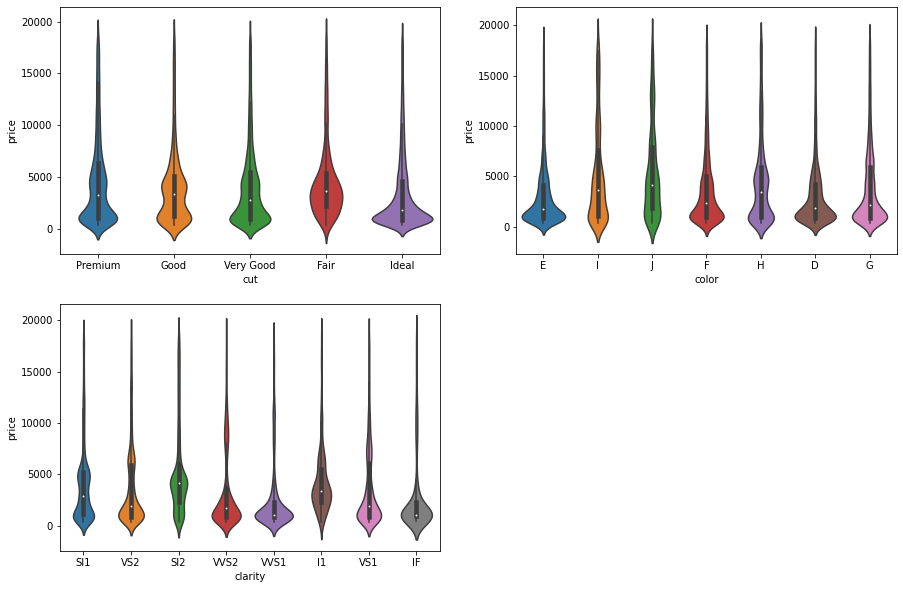

In [ ]:
# check categorical columns in the dataframe
# show how points variant in cut, clarity, colors features
cat_values= data.select_dtypes(include=['object']).columns.tolist()
vio_categorical(x= cat_values, y= 'price', data= data)

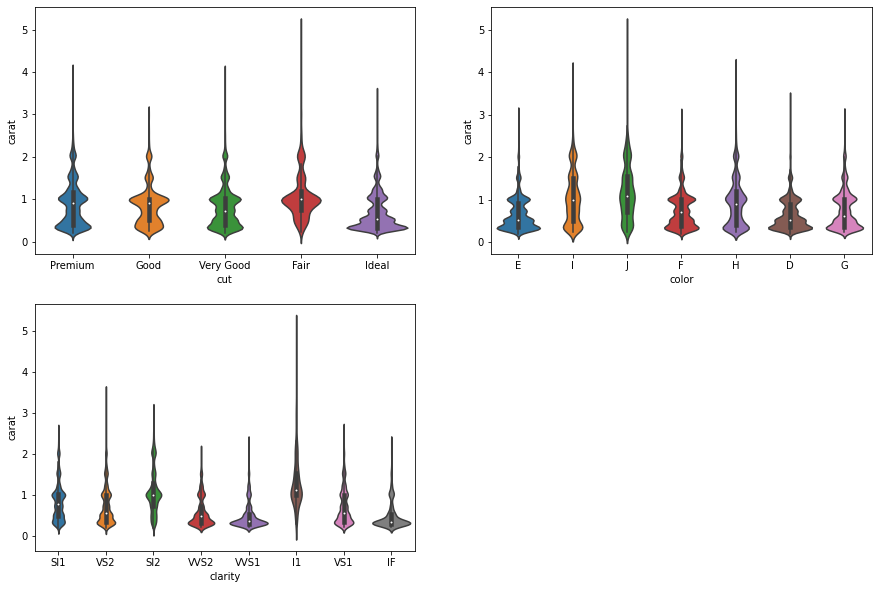

In [ ]:
# lately I consider high correlation between carat and diamond price so I will consider it in the analysis of categorical data.
# check categorical columns in the dataframe
# show how points variant in cut, clarity, colors features
cat_values= data.select_dtypes(include=['object']).columns.tolist()
vio_categorical(x= cat_values, y= 'carat', data= data)

**I will also view the correlation between price and categories data**

#### Plot bars to describe the count effect between categorical features and other features.

In [ ]:
def barplots(data, feature_lst, target):
  '''
  Plot barplots of the correlation between two feature, here the purpose is between categorical features and other features.
  Args:
  data-- dataframe of the data we working on it.
  feature-- list strs the feature to study
  target-- the y coordinate that represents the target variable
  '''
  # create the blank figure
  plt.figure(figsize=(15,10))
  for index, element in enumerate(feature_lst):
      # enumerate the subplots
      plt.subplot(np.ceil(len(feature_lst)/2),2, index+1)
      # plot barplot
      sns.barplot(x= element, y= target, data= data)

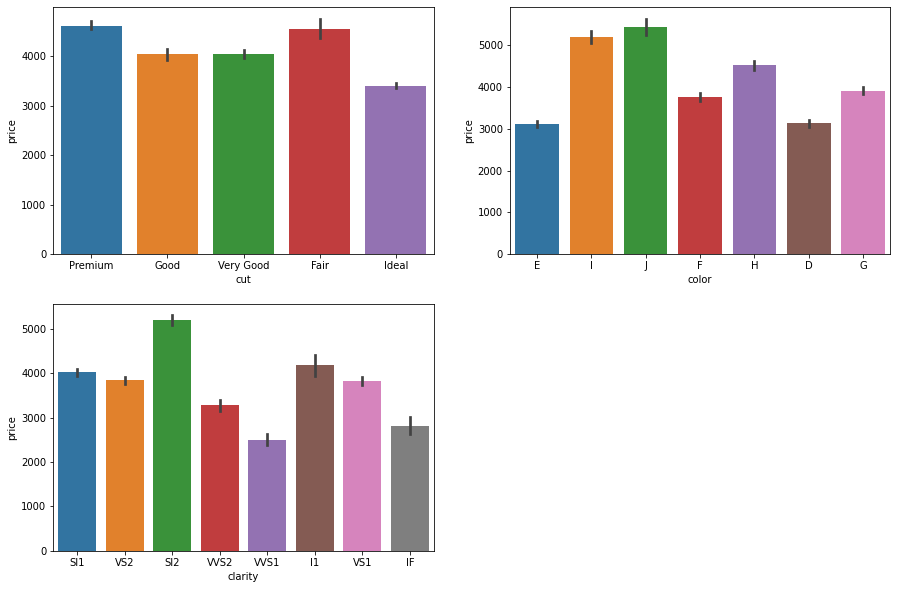

In [ ]:
cat_values= data.select_dtypes(include=['object']).columns.tolist()
barplots(data, cat_values, 'price')

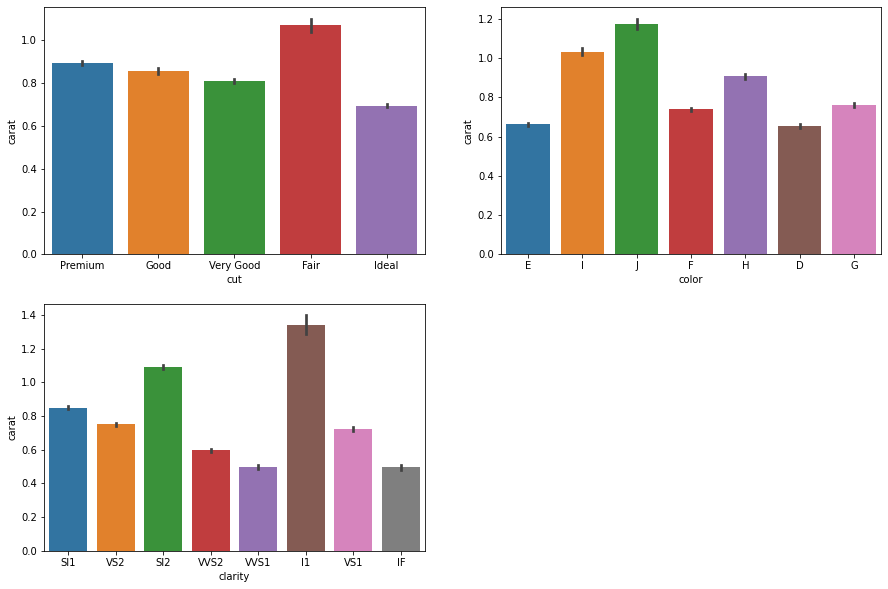

In [ ]:
# lately I consider high correlation between carat and diamond price so I will consider it in the analysis of categorical data.
cat_values= data.select_dtypes(include=['object']).columns.tolist()
barplots(data, cat_values, 'carat')

**Discussion Stage**\
From the plots above, the difference between categorical variables are low, so Lately I tried to use OneHotEncoder, and after the analysis check, I continued with Ordinal encoder.

# Split Data to Train, and Validation splits

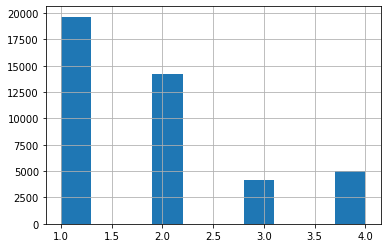

In [3]:
# consider sampling depends on price categories
data["price_cat"] = pd.cut(data["price"],
                            bins=[0., 2000.0, 6000.0, 9000.0, np.inf],
                            labels=[1, 2, 3, 4])
# price categories represent
data["price_cat"].hist()

In [4]:
# apply a stratified shuffle split on the train csv
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["price_cat"]):
      strat_train_set = data.loc[train_index]
      strat_test_set = data.loc[test_index]

**Check the statistics results of the splits**

In [5]:
# check the statistics of the train set
strat_train_set["price_cat"].value_counts() / len(strat_train_set)

1    0.456436
2    0.329984
4    0.117100
3    0.096480
Name: price_cat, dtype: float64

In [6]:
# check the statistics of the test set
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

1    0.456436
2    0.330042
4    0.117100
3    0.096422
Name: price_cat, dtype: float64

In [7]:
# drop the price_cat column from the sets
for col in (strat_train_set, strat_test_set):
  col.drop("price_cat", axis=1, inplace=True)

In [8]:
# recheck the shape and the data
print(f"\nThe shape of train set is\n {strat_train_set.shape}")
# check the first 5 rows in the train set
strat_train_set.head()


The shape of train set is
 (34432, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
39109,48459,0.51,Ideal,G,VVS2,62.7,55.0,1976,5.08,5.10,3.19
30897,38451,0.31,Ideal,E,VVS1,62.4,56.0,1028,4.37,4.35,2.72
31311,38942,0.31,Very Good,H,VS2,62.2,59.0,489,4.34,4.38,2.71
38813,48091,1.00,Premium,H,I1,60.4,61.0,1932,6.39,6.32,3.84
42625,53397,0.72,Premium,E,SI1,61.3,58.0,2666,5.81,5.78,3.55


In [9]:
# check the first 5 rows in the test set
print(f"The shape of the test set is\n {strat_test_set.shape}")
strat_test_set.head()

The shape of the test set is
 (8608, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
12798,15804,1.21,Very Good,E,SI1,62.9,58.0,6324,6.78,6.79,4.27
902,1198,0.71,Ideal,D,SI2,62.0,54.0,2934,5.77,5.74,3.57
17559,21892,1.52,Premium,H,SI1,60.1,60.0,9959,7.45,7.39,4.46
17891,22321,1.57,Ideal,E,SI2,61.4,56.0,10362,7.44,7.52,4.59
11870,14725,0.30,Premium,G,VS1,61.4,60.0,605,4.30,4.33,2.65


# Preprocessing Time

**Discussion Stage** \
I see that Unnamed: 0 column has no positive effect on the model and it would make the training accuracy worse. And the correlation plots of it define strange lines shows counting columns, So I have to remove it.

In [10]:
# remove Unnamed: 0 from the data
train_data= strat_train_set.drop(['Unnamed: 0'], axis=1)
train_data.reset_index(drop= True, inplace= True)
test_data= strat_test_set.drop(['Unnamed: 0'], axis=1)
test_data.reset_index(drop= True, inplace= True)
# I will add it in the column transformer

In [11]:
# check if removing process is successful on train set
print(train_data.shape)
train_data.head()

(34432, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.51,Ideal,G,VVS2,62.7,55.0,1976,5.08,5.10,3.19
1,0.31,Ideal,E,VVS1,62.4,56.0,1028,4.37,4.35,2.72
2,0.31,Very Good,H,VS2,62.2,59.0,489,4.34,4.38,2.71
3,1.00,Premium,H,I1,60.4,61.0,1932,6.39,6.32,3.84
4,0.72,Premium,E,SI1,61.3,58.0,2666,5.81,5.78,3.55


In [12]:
# check if removing process is successful on test set
print(test_data.shape)
test_data.head()

(8608, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Very Good,E,SI1,62.9,58.0,6324,6.78,6.79,4.27
1,0.71,Ideal,D,SI2,62.0,54.0,2934,5.77,5.74,3.57
2,1.52,Premium,H,SI1,60.1,60.0,9959,7.45,7.39,4.46
3,1.57,Ideal,E,SI2,61.4,56.0,10362,7.44,7.52,4.59
4,0.30,Premium,G,VS1,61.4,60.0,605,4.30,4.33,2.65


**Note**: with these statistics, pairplot, and boxplot I can determine outliers.

**Discussion Stage**
* There is no null values, also there is 6 numericals feature without the target, and 3 categorical features

In [13]:
# check duplecated values
train_data.duplicated().sum()

76

**Discussion Stage**\
There are some duplicate values, maybe it will affect the performance, so I will remove it.

In [14]:
train_data.drop_duplicates(keep='first', inplace= True)
# recheck if the duplicated values issue has been solved
train_data.duplicated().sum()

0

In [15]:
#check zeros in the data
def contain_zeros(data):
  '''
  Returns if the numeric colomns contain zeros
  Args:
  data-- dataframe contain the data
  Returns:
  Prints if columns contain zeros
  '''
  # select numeric data type
  for column in data.select_dtypes(exclude=['object']).columns.tolist():
    # check if it's ccontain zeros
    if (data[column]== 0).any() :
      print(f"{column} contain zeros")
    else:
      print(f"{column} has not contain zeros")
  return None
contain_zeros(train_data)

carat has not contain zeros
depth has not contain zeros
table has not contain zeros
price has not contain zeros
x contain zeros
y contain zeros
z contain zeros


In [16]:
# try to drop or replace zeros
def drop_zeros(data, replace= np.nan, drop =True):
  '''
  Returns dataframe without zeros if the numeric colomns contain zeros.
  Args:
  data-- dataframe contain the data.
  replace-- function or value describes the replace value.
  drop-- boolian to determine drop zeros or not.
  Returns:
  Dataframe without zeros.
  '''
  for column in data.select_dtypes(exclude=['object']).columns.tolist():
    if drop == False:
      data[column].replace(0, np.mean(data[column]), inplace= True)
    else:
      data[column].replace(0, replace, inplace= True)
      data.dropna(inplace= True)
  return data
train_data= drop_zeros(train_data, drop= True)
contain_zeros(train_data)

carat has not contain zeros
depth has not contain zeros
table has not contain zeros
price has not contain zeros
x has not contain zeros
y has not contain zeros
z has not contain zeros


**Discussion Stage**
* Drop zeros cause big overfit and bad results.
* But when dropping outliers and using MinMaxScaler it will not cause overfit.
* Drop zeros while replacing outliers with mean values or threshold is the best.

### Check the correlation in the training data

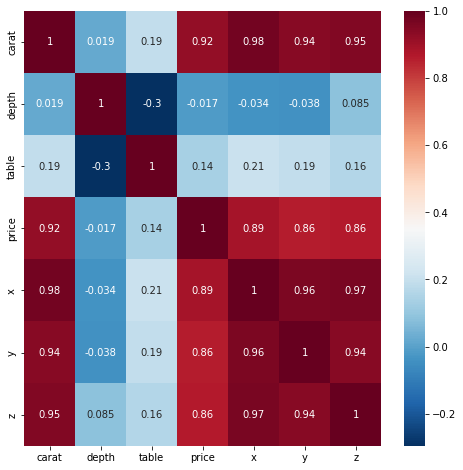

In [17]:
# plotting heatmap correlations between data

# create the blank figure
fig = plt.figure(figsize=(8, 8))

# plot heatmap between data features (numerical data), I dropped unnamed here to not affect the judgment because I clearly see that Unnamed: 0 has no effect on the model.
sns.heatmap(train_data.corr(), annot=True, cmap='RdBu_r')
plt.show()

**Discussion Stage**\
Heatmap clearly explains the correlation between numerical features, so:
* There is a good correlation between depth and table.
* Table feature has a good role in the data.
* Because all other features have high correlation and close to each others, so we can ignore the effect of the high correlation that would cause overfit.
* Unnamed: 0 seems to be randomized, or counting, or noise in the data.

### Determine the outliers

In [18]:
def box_plot(features, data):
    '''
    Plot boxes that describes and determine the outliers in the features.
    Args:
    features-- list of features we want to study their outliers.
    data-- dataframe we want to deal with.
    Returns:
    A plot describe the outliers in the features
    '''
    # create the blank figure
    plt.figure(figsize=(20,10))
    for index, element in enumerate(features):
        plt.subplot(np.ceil(len(features)/2),2, index+1)
        # plot lines
        # initialize subplots index values
        sns.boxplot(x= element, data= data)
        plt.title(f"Distribution of {element}")
        # set x and y labels
        plt.xlabel(element)
    # adjust height space
    plt.subplots_adjust(wspace= 0.4, hspace = 0.8)
    return plt.show()

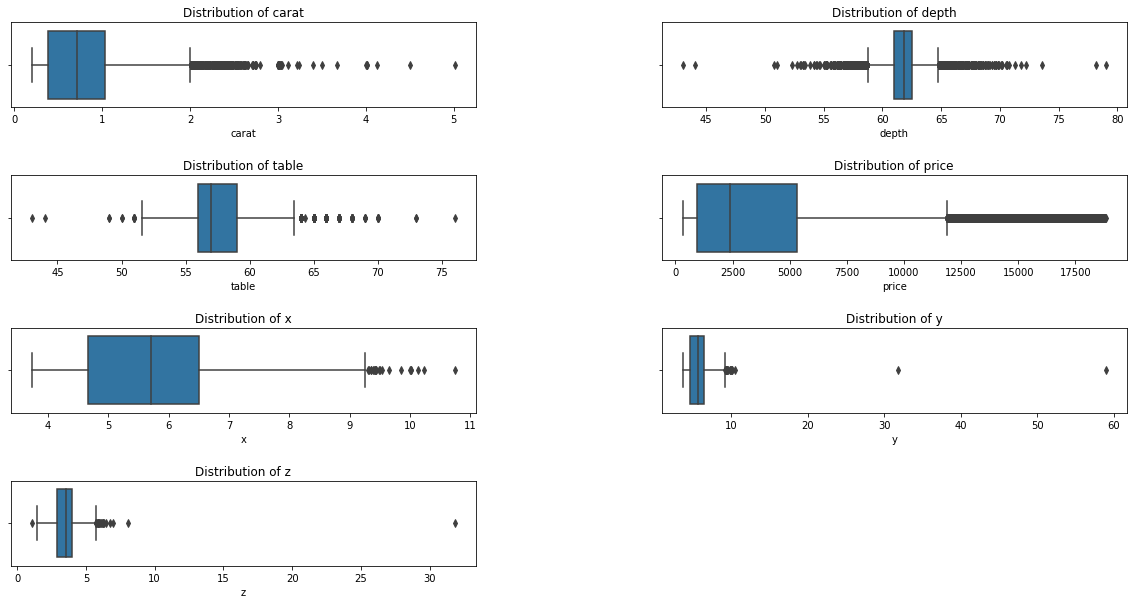

the shape of train_data is:  (34342, 10)


In [19]:
# initialize numeric features
features= train_data._get_numeric_data().columns.to_list()
# check the outliers in features
box_plot(features, train_data)
# check the data shape
print("the shape of train_data is: ", train_data.shape)

***Discussion Stage***\
Remove outliers from features, depending on Q1, Q3 values from the description of the data, pairplot, and the histogram of each feature.\
Also, I will try to convert outliers to nan, std, or mean

### Remove Outliers

#### Replace outliers with threshold value

In [20]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

In [21]:
def check_outliers_iqr(dataframe, col_name):
    lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)].any(axis=None):
        return True
    else: 
        return False

In [22]:
def replace_with_thresholds_iqr(dataframe, cols, th1=0.05, th3=0.95, replace=False):
    data = []
    for col_name in cols:
      if col_name !=  'price' or 'cut' or	'color'	or 'clarity':
        outliers_ = check_outliers_iqr(dataframe, col_name)
        count = None
        lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name, th1, th3)
        if outliers_:
          count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
          if replace: 
              if lower_limit < 0:
                  # We don't want to replace with negative values
                  dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
              else:
                  dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
                  dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
          outliers_status = check_outliers_iqr(dataframe, col_name)
          data.append([outliers_, outliers_status, count, col_name, lower_limit, upper_limit ])
    table = tabulate(data, headers=['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using IQR")
    print(table)
# get features from data
features= train_data._get_numeric_data().columns.to_list()
# recheck the outliers in featuers
replace_with_thresholds_iqr(train_data, features, replace= True)

Removing Outliers using IQR
=======================  ==========  =======  ========  =============  =============
Outliers (Previously)    Outliers      Count  Column      Lower Limit    Upper Limit
=======================  ==========  =======  ========  =============  =============
True                     True              6  carat            -1.845          3.875
True                     True             14  depth             52.55          70.55
True                     True              4  table              43.5           71.5
True                     True              0  price          -18555.8        32387.7
True                     True              0  x                -0.898         12.938
True                     True              2  y                 -0.83          12.85
True                     True              2  z                -0.505          7.935
=======================  ==========  =======  ========  =============  =============


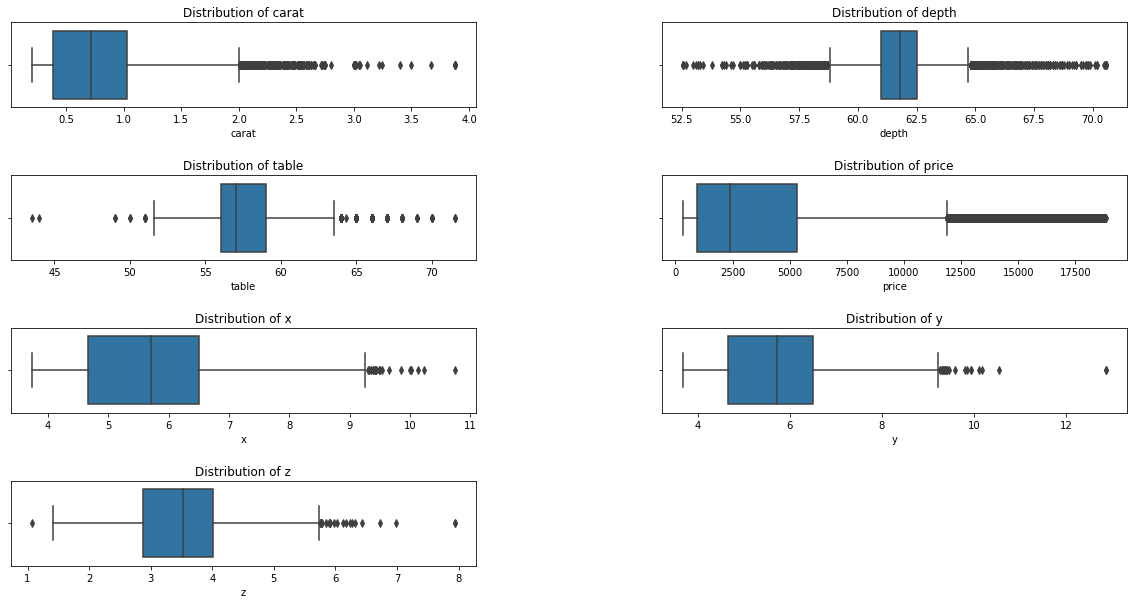

In [23]:
# get features from data
features= train_data._get_numeric_data().columns.to_list()
# recheck the outliers in featuers
box_plot(features, train_data)

**Discussion Stage**\
In the case of replace outliers with std or mean. it's been good on mean or threshold, not on std on the performance.\
**Notice that replace the outliers with a standard deviation as depending on distribution is not good.**
1. Despite the left skew of the distribution of the samples, replacing the extreme samples with std is bad.
2. Drop the outlier values also cause bad results, and overfit.
3. Replace outliers with mean or threshold, or the value of ~95% and ~0.05% of the quantiles is the best.

There are also some points in the price target, but I will ignore it to prevent overfitting.
1. I have to notice that I tried mean and median replace of nan values.
3. Going in 2 step of delete the outliers again also cause the performance get worse.

**Before moving to encoding, we should standardize the data
I will try to add some feature engineering approach
So I use Column Transformers.**

In [24]:
# recheck data information
train_data.describe()

,carat,depth,table,price,x,y,z
count,34342.000000,34342.000000,34342.000000,34342.000000,34342.000000,34342.000000,34342.000000
mean,0.796647,61.745888,57.432951,3944.337488,5.725278,5.727514,3.535350
std,0.480627,1.417501,2.225830,4023.679672,1.129661,1.122613,0.697906
min,0.200000,52.550000,43.500000,326.000000,3.730000,3.680000,1.070000
25%,0.380000,61.000000,56.000000,941.000000,4.660000,4.670000,2.870000
50%,0.710000,61.800000,57.000000,2391.000000,5.710000,5.720000,3.530000
75%,1.030000,62.500000,59.000000,5315.000000,6.500000,6.500000,4.020000
max,3.875000,70.550000,71.500000,18823.000000,10.740000,12.850000,7.935000


#### Correlation analysis

In [25]:
def feature_eng(data= train_data):
  temp_data= data.copy()
  temp_data["cut"] = temp_data.cut.map({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4})
  temp_data["color"] = temp_data.color.map({"D":0, "E":1, "F":2, "G":3, "H":4, "I":5, "J":6})
  temp_data["clarity"] = temp_data.clarity.map({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7})
  temp_data["size"]= temp_data["x"]*temp_data["y"]*temp_data["z"]
  temp_data.drop(['depth'], axis= 1, inplace=True)
  return temp_data

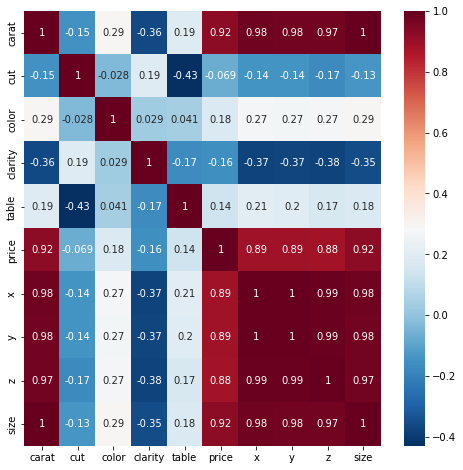

In [26]:
feature_eng_data = feature_eng(data= train_data) # for correlation testing purpose
# plotting heatmap correlations between new data
# create blank figure
fig = plt.figure(figsize=(8, 8))
# plot heatmap between data features (numerical data)
sns.heatmap(feature_eng_data.corr(), annot=True, cmap='RdBu_r')
plt.show()

**Discussion Stage**
* carat, size, x, y, z, color, clarity have a hight correlation with the target and other features.
* depth has a very low correlation with the target and other features.
* table, and cut have a low correlation with the target and other features.

#### Prepare data for training

In [27]:
# build training features
training_data= train_data.drop(["price"], axis= 1)
# build training target
if train_data['price'].any()== np.nan:
  # check any null values and replace it with mean
    train_data['price'].fillna(0, inplace= True)
price_value= np.mean(train_data['price'])
data_labels= train_data[['price']].replace(to_replace= 0, value= price_value)
# convert the label data to vector
data_labels= data_labels.values.ravel()
# get numerical vaiables as list
numerical_attribs = list(training_data.select_dtypes(exclude='object'))
# get categorical vaiables as list
categorical_attribs = list(training_data.select_dtypes(include='object'))

In [28]:
carat_index, table_index, depth_index, x_index, y_index, z_index = [
    numerical_attribs.index(col)
    for col in ("carat", "table", "depth", "x", "y", "z")]
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # store features name attributes for later analysis
    get_feature_names_= []
    def return_features_name(self):
      return self.get_feature_names_
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # convert zero values to std get bad results, so I replace it with mean values
        X[:, carat_index]= np.where(X[:, carat_index]== 0, np.mean(X[:, carat_index]), X[:, carat_index])
        X[:, depth_index]= np.where(X[:, depth_index]== 0, np.mean(X[:, depth_index]), X[:, depth_index])
        X[:, table_index]= np.where(X[:, table_index]== 0, np.mean(X[:, table_index]), X[:, table_index])
        X[:, x_index]= np.where(X[:, x_index]== 0, np.mean(X[:, x_index]), X[:, x_index])
        X[:, y_index]= np.where(X[:, y_index]== 0, np.mean(X[:, y_index]), X[:, y_index])
        X[:, z_index]= np.where(X[:, z_index]== 0, np.mean(X[:, z_index]), X[:, z_index])
        # feature engineering
        size= X[:, x_index] * X[:, y_index] * X[:, z_index]
        X= np.delete(arr= X, obj= [depth_index], axis= 1)
        self.get_feature_names_+=["carat", "table","x", "y", "z", "size"]
        return np.c_[X, size]

In [29]:
class CategoricalAttributesConverter(BaseEstimator, TransformerMixin):
    # store features name attributes for later analysis
    get_feature_names_= []
    def return_features_name(self):
      return self.get_feature_names_
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
      X["cut"] = X.cut.map({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4})
      self.get_feature_names_+= ['cut']
      X["color"] = X.color.map({"D":0, "E":1, "F":2, "G":3, "H":4, "I":5, "J":6})
      self.get_feature_names_+= ['color']
      X["clarity"] = X.clarity.map({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7})
      self.get_feature_names_+= ["clarity"]
      return X

**Discussion Stage**
* In case of not delete x, y, z, the model performs well, and the depends on it separately.
* I think it's because the high correlation with other features and with the target.
* Consider all categorical attributes as random ranking will cause a worse performance.
* Consider deleting table, and cut will cause a worse performance.
* Consider cut as a random category encoded.

In [30]:
# I used a pipeline to a later combination of transformer
num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy="mean")),
  ('feature_eng', CombinedAttributesAdder()),
  ('scaler',  StandardScaler())
])

**Dicussion Stage**
1. Using MinMax Scaler after delete outliers will cause the model to get the same performance when I convert the outliers to mean.
2. Using Robust Scaler prevents us from using manual functions to determine outliers to remove it, it can remove and scaling features with the same mechanism and the same results, and its approximation the same performance with RobustScaler, QuantileTransformer, PowerTransformer, even for diffrent columns scaler.

In [31]:
# combine all transformer together.
full_pipeline = ColumnTransformer([
 ("numerical", num_pipeline, numerical_attribs),
 ("categorical", CategoricalAttributesConverter(), categorical_attribs),
 ])

In [32]:
data_prepared = full_pipeline.fit_transform(training_data)
data_prepared.shape

(34342, 9)

In [33]:
# for later analysis I will convert it to dataframe
data_prepared_df = pd.DataFrame(data=data_prepared, columns=num_pipeline.named_steps["feature_eng"].return_features_name()+full_pipeline.named_transformers_["categorical"].return_features_name())
data_prepared_df

,carat,table,x,y,z,size,cut,color,clarity
0,-0.596411,-1.093069,-0.571222,-0.558985,-0.494844,-0.605193,4.0,3.0,5.0
1,-1.012540,-0.643792,-1.199739,-1.227079,-1.168297,-1.003273,4.0,1.0,6.0
2,-1.012540,0.704039,-1.226296,-1.200355,-1.182625,-1.005729,2.0,4.0,3.0
3,0.423105,1.602594,0.588435,0.527782,0.436527,0.326700,3.0,4.0,0.0
4,-0.159476,0.254762,0.074999,0.046754,0.020992,-0.134700,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...
34337,1.026491,0.254762,1.119576,1.160244,1.152966,1.075351,2.0,0.0,1.0
34338,-0.617217,-0.194515,-0.509256,-0.585709,-0.580817,-0.617038,2.0,3.0,6.0
34339,-1.033346,-0.643792,-1.244001,-1.218171,-1.239941,-1.021489,4.0,2.0,6.0
34340,0.943266,-0.194515,0.977938,1.008809,1.066993,0.911542,2.0,6.0,2.0


**Discussion Stage**
* All numerical data standardized, and all categorical encodings transform to ordinal encoding.
* Final features have good correlation with the target.
* When I try to use OneHotEncoding depending on the plots previously, I see no big change on the results and performance.

# Model training time

**Note**: I will try all algorithms separately with all its results to better understand it.

*Beside basic evaluation, we also have to evaluation using Cross-Validation to better evaluate our models we use Cross-Validation*

In [34]:
def cross_val(name, model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10):
  '''
  Prints the evaluation values.
  Args:
  name-- str type represents the name of the estimator.
  model-- the model we want to evaluate by.
  X-- training data.
  Y-- labeled data.
  scoring-- scoring metric.
  cv-- int describe the number of kfolds.
  Returns:
  The evaluation metric of the model.
  '''
  # create an instance of the model in cross_val_score and initialize it.
  model_cross_val= cross_val_score(estimator= model,
                            X= X, y= y,
                            scoring= scoring, cv= cv)
  # calculate root of the cross_val result because of the cross validation compute the negative mean squared error,
  # so I reverse the sign and compute the root.
  model_cross_val_score= np.sqrt(-model_cross_val)
  # display the basic results of cross validation step
  print('''
  {name} Regression Cross Validation Mean Result is: {mean}\n\
  {name} Regression Cross Validation Standard Deviation Result is: {std}\n\
  {name} Regression Cross Validation Score Result is:\n{score}'''.format(name= name, mean= model_cross_val_score.mean(), std= model_cross_val_score.std(), score= model_cross_val_score))

In [ ]:
def learning_plot(name, model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10):
  '''
  Prints the evaluation values.
  Args:
  name-- str type represents the name of the estimator.
  model-- the model we want to evaluate by.
  X-- training data.
  Y-- labeled data.
  scoring-- scoring metric.
  cv-- int describe the number of kfolds.
  Returns:
  The evaluation metric of the model.
  '''
  train_sizes = [1, 4700, 8000, 11000, 14300, 16000, 20000, 23670, 27473]
  train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model,
    X = X,
    y = y, train_sizes = train_sizes, cv = 5,
    scoring = scoring)
  # training scores
  print('Training scores:\n\n', np.sqrt(-train_scores))
  print('\n', '-' * 70) # separator to make the output easy to read
  # validation scores
  print('\nValidation scores:\n\n', np.sqrt(-validation_scores))
  train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
  validation_scores_mean = np.sqrt(-validation_scores).mean(axis = 1)
  print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
  print('\n', '-' * 20) # separator
  print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
  plt.style.use('seaborn')
  # plot training scores
  plt.plot(train_sizes, train_scores_mean, label = 'Training error')
  # plot validation scores
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
  # plot ylabel
  plt.ylabel('RMSE', fontsize = 14)
  # plot xlabel
  plt.xlabel('Training set size', fontsize = 14)
  # plot title
  plt.title(f'Learning curves for a {name} Regression model', fontsize = 18, y = 1.03)
  plt.legend()
  return plt.show()

In [ ]:
# create storing result variable, represents the algorithm results
algorithm_results= {}

### Best Algorithms

#### Decision Tree Regressor model

In [ ]:
# create an object of the Decision Tree Regressor class
tree_reg_obj = DecisionTreeRegressor(splitter= "best", random_state= 42, max_features=None)
# fit the training data on the training set
tree_reg_model= tree_reg_obj.fit(data_prepared, data_labels)
# now evaluate Decision Tree Regressor model on the training set, Using Scikit-Learn’s root_mean_squared_error function
# compute mean squared error on the whole training set
tree_reg_mse = mean_squared_error(data_labels, tree_reg_model.predict(data_prepared))
# compute the root of the computed mean square error
tree_reg_rmse = np.sqrt(tree_reg_mse)
algorithm_results['DecisionTree']= tree_reg_rmse
tree_reg_rmse

10.195672390001883

Explaine this result
The rmse here is very low. This case suggests an overfit problem in the training set

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Decision Tree", tree_reg_obj)


  Decision Tree Regression Cross Validation Mean Result is: 768.3999440126524
  Decision Tree Regression Cross Validation Standard Deviation Result is: 30.103502671579292
  Decision Tree Regression Cross Validation Score Result is:
[797.11983949 747.72300311 825.58723814 779.29285217 788.30147616
 772.40019872 743.57163557 712.36606937 752.95001757 764.68710983]


Training scores:

 [[ 0.          0.          0.          0.          0.        ]
 [15.32653796  3.91940074  3.91940074  3.91940074  3.91940074]
 [12.32385897  3.99743668  3.34473467  3.34473467  3.34473467]
 [10.85483763  4.7970635  10.58178538 10.58178538 10.58178538]
 [ 9.76234381  5.17952194 10.26479318 10.34655782 10.34655782]
 [ 9.27617917  5.14582051  9.78974751  9.94571359  9.94571359]
 [10.49474154  7.64663488 10.083277    9.47210906  9.47210906]
 [10.9000374   8.51790033 10.59673687  9.48613156  9.37290182]
 [10.34763035  8.314581   10.0552599   9.10208347 10.04061928]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 910.49245275  898.6621549   909.08402735  873.72639818  881.49277905]
 [ 871.13267505  820.50156828  870.50758503  819.47941191  788.03104105]
 [ 885.90943737  852.74344681  859.00464309  837.97015772  842.01453525]
 [ 828.72999014  772.27325

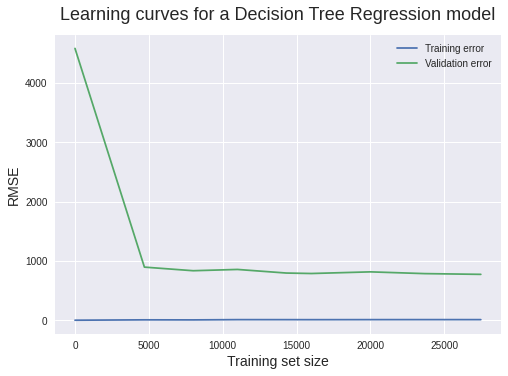

In [ ]:
# Evaluation Using learning curve
learning_plot("Decision Tree", tree_reg_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Random Forest Regressor model.

In [ ]:
# create an object the of Random Forest class
forest_obj = RandomForestRegressor(n_estimators= 500, random_state= 42, max_features=5)
# fit the training data on the training set
forest_model= forest_obj.fit(data_prepared, data_labels)
# now evaluate Random Forest Regressor model on the training set
# compute mean squared error on the whole training set
forest_mse = mean_squared_error(data_labels, forest_model.predict(data_prepared))
# compute the root of the computed mean squared error
forest_rmse = np.sqrt(forest_mse)
algorithm_results['RandomForest']= forest_rmse
forest_rmse

204.5122746422688

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Random Forest", forest_obj)


  Random Forest Regression Cross Validation Mean Result is: 559.796318327086
  Random Forest Regression Cross Validation Standard Deviation Result is: 19.2397878589333
  Random Forest Regression Cross Validation Score Result is:
[582.62247873 564.06188806 592.87944341 549.72071782 579.51330008
 556.76700597 549.17368524 539.38538545 556.06037595 527.77890258]


Training scores:

 [[  0.           0.           0.           0.           0.        ]
 [254.34842495 242.78700158 242.78700158 242.78700158 242.78700158]
 [232.6413583  226.96744273 228.36984389 228.36984389 228.36984389]
 [226.77940173 226.37949084 226.95727097 226.95727097 226.95727097]
 [220.12104849 219.45622122 219.73930416 219.45509366 219.45509366]
 [217.41074008 217.60249391 217.21864669 219.97915282 219.97915282]
 [213.08238374 213.10647642 213.49700043 213.40909241 213.40909241]
 [210.19052041 210.41592111 209.85959682 211.13460507 210.6073856 ]
 [208.07265833 206.58450375 206.98298427 209.26788018 208.58808898]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 677.95022786  673.31550346  661.8432441   643.48045918  640.16048462]
 [ 643.50832138  638.33237136  619.8687778   614.41994201  603.92635503]
 [ 631.36626775  616.64976811  601.70268022  589.92125

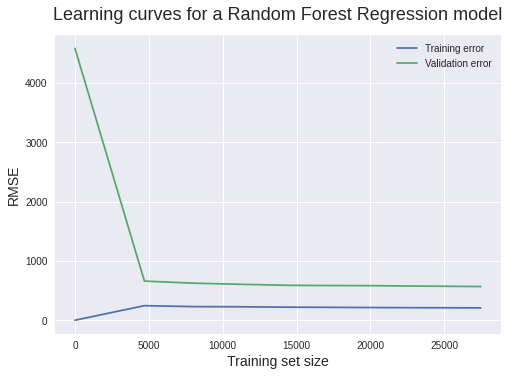

In [ ]:
# Evaluation Using learning curve
learning_plot("Random Forest", forest_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Grandient Boosting

In [ ]:
# create an object the of GradientBoosting class
grad_boosting_obj= GradientBoostingRegressor(n_estimators= 500, learning_rate= 0.1, random_state= 42, criterion ='squared_error', max_features=5)
grad_boosting_model= grad_boosting_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
grad_boosting_model_mse = mean_squared_error(data_labels, grad_boosting_model.predict(data_prepared))
# compute the root of the computed mean squared error
grad_boosting_model_rmse = np.sqrt(grad_boosting_model_mse)
algorithm_results['GrandientBoosting']= grad_boosting_model_rmse
grad_boosting_model_rmse

493.54547730882916

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("GB", grad_boosting_obj)


  GB Regression Cross Validation Mean Result is: 572.9235903025376
  GB Regression Cross Validation Standard Deviation Result is: 25.883433735401617
  GB Regression Cross Validation Score Result is:
[593.06876868 576.23178193 610.9160494  566.23916724 616.8381505
 556.25704221 540.26964004 558.63132953 574.14185024 536.64212326]


Training scores:

 [[  0.           0.           0.           0.           0.        ]
 [373.55863253 336.51081571 336.51081571 336.51081571 336.51081571]
 [413.73077724 399.4051939  408.49829632 408.49829632 408.49829632]
 [441.6777537  430.05951381 437.71786896 437.71786896 437.71786896]
 [458.19718032 443.85759736 456.59147348 455.22895228 455.22895228]
 [466.86637689 453.674129   467.08963544 464.46449917 464.46449917]
 [476.12159598 459.70968394 471.53288203 476.33859555 476.33859555]
 [480.44922493 479.48169446 484.58214228 491.89299631 485.9632211 ]
 [483.17116647 485.74032008 488.81984461 494.31440913 491.45238698]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 667.6666961   648.26822107  656.5950922   612.97148408  619.70044937]
 [ 639.53419779  621.52043232  622.47502331  594.519015    590.83723701]
 [ 630.14317763  606.53238062  604.35772423  585.65707

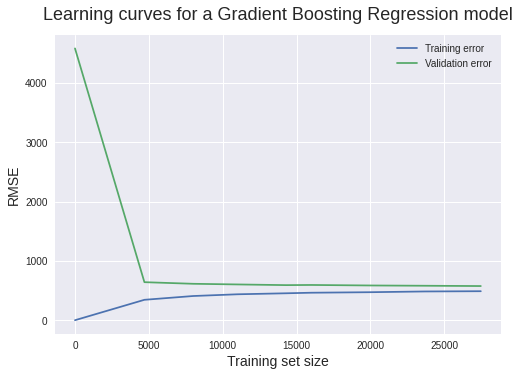

In [ ]:
# Evaluation Using learning curve
learning_plot("Gradient Boosting", grad_boosting_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### XGB Regressor

In [ ]:
# create an object the of XGB Regressor class
XGB_reg = xgb.XGBRegressor(n_estimators= 600, reg_lambda= 2.0, learning_rate= 0.1, objective ='reg:squarederror', random_state= 42, max_features=5)
XGB_model= XGB_reg.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
XGB_model_mse = mean_squared_error(data_labels, XGB_model.predict(data_prepared))
# compute the root of the computed mean squared error
XGB_model_rmse = np.sqrt(XGB_model_mse)
algorithm_results['XGB']= XGB_model_rmse
XGB_model_rmse

486.4176657866614

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("XGB", XGB_reg)


  XGB Regression Cross Validation Mean Result is: 570.3317613489842
  XGB Regression Cross Validation Standard Deviation Result is: 31.928694243465838
  XGB Regression Cross Validation Score Result is:
[582.38878346 562.07009738 606.00671128 563.3695432  645.22657106
 560.61854935 539.13050268 545.30879175 565.35775997 533.84030337]


Training scores:

 [[8.54492188e-04 1.70898438e-03 1.70898438e-03 1.70898438e-03
  1.70898438e-03]
 [3.61326047e+02 3.35452939e+02 3.35452939e+02 3.35452939e+02
  3.35452939e+02]
 [4.09597578e+02 3.87329288e+02 3.91522512e+02 3.91522512e+02
  3.91522512e+02]
 [4.22736651e+02 4.25529706e+02 4.30087760e+02 4.30087760e+02
  4.30087760e+02]
 [4.42634030e+02 4.36148336e+02 4.42168767e+02 4.42065035e+02
  4.42065035e+02]
 [4.59227358e+02 4.42145066e+02 4.51907466e+02 4.49345825e+02
  4.49345825e+02]
 [4.59293774e+02 4.53742551e+02 4.55436189e+02 4.59357169e+02
  4.59357169e+02]
 [4.74686539e+02 4.68850816e+02 4.69301341e+02 4.69557546e+02
  4.72042464e+02]
 [4.73919486e+02 4.73037145e+02 4.71352878e+02 4.78562447e+02
  4.79237788e+02]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56812267 4552.09453025 4465.65238593 4401.99544655 4521.64403142]
 [ 646.70749271  641.56038965  656.62438047  601.63509103  605.34102261]
 [ 625.54264897  62

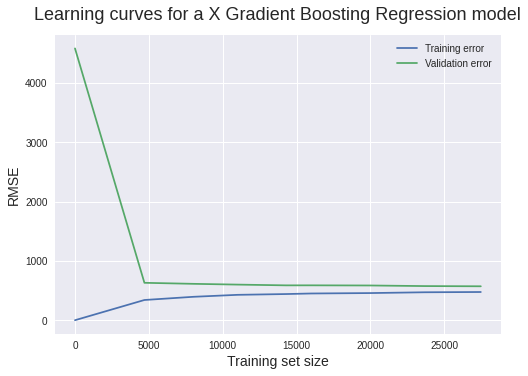

In [ ]:
# Evaluation Using learning curve
learning_plot("X Gradient Boosting", XGB_reg, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Extra Trees Regressor

In [ ]:
# create an object the of Extra trees Regressor class
extra_trees_reg = ExtraTreesRegressor(n_estimators=500, random_state=42, max_features=5)
extra_trees_model= extra_trees_reg.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
extra_trees_model_mse = mean_squared_error(data_labels, extra_trees_model.predict(data_prepared))
# compute the root of the computed mean squared error
extra_trees_model_rmse = np.sqrt(extra_trees_model_mse)
algorithm_results['Extra Trees']= extra_trees_model_rmse
extra_trees_model_rmse

10.196434417904293

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Extra Trees", extra_trees_model)


  Extra Trees Regression Cross Validation Mean Result is: 551.1790683463466
  Extra Trees Regression Cross Validation Standard Deviation Result is: 17.84969005397438
  Extra Trees Regression Cross Validation Score Result is:
[576.54584913 547.23631254 583.68622389 543.61073083 562.9160021
 547.87429369 542.50832056 535.98472462 551.20675297 520.22147314]


Training scores:

 [[ 0.          0.          0.          0.          0.        ]
 [15.32654068  3.91959779  3.91959779  3.91959779  3.91959779]
 [12.32389794  4.1639563   3.34484049  3.34484049  3.34484049]
 [10.85570584  4.81640186 10.58182532 10.58182532 10.58182532]
 [ 9.76243853  5.19685568 10.26487164 10.34690883 10.34690883]
 [ 9.27631576  5.15570048  9.78988238  9.94816889  9.94816889]
 [10.49485038  7.65000467 10.08359646  9.47354335  9.47354335]
 [10.90010626  8.51973679 10.59770513  9.48662692  9.37407487]
 [10.347771    8.31572831 10.05657851  9.10270099 10.04146827]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 649.61138106  646.85612414  624.32975657  611.85838182  610.92300528]
 [ 622.59025736  627.91093337  599.81431331  596.19094422  583.54683567]
 [ 612.69362876  604.73068592  584.32497521  574.20253975  575.71298781]
 [ 595.95778073  589.00819

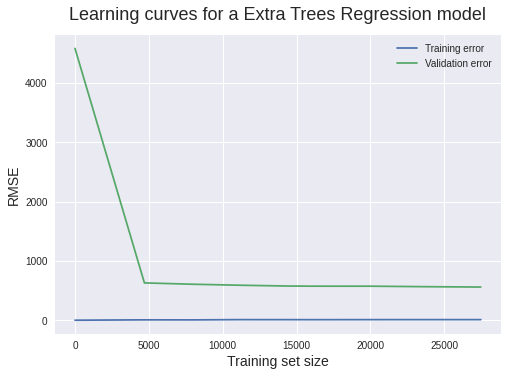

In [ ]:
# Evaluation Using learning curve
learning_plot("Extra Trees", extra_trees_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### K-Nearest Neighbors

In [ ]:
# create an object the of K-NN class
knn_obj= KNeighborsRegressor(weights="distance", n_neighbors= 5, p=1, algorithm="auto")
knn_model= knn_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
knn_mse = mean_squared_error(data_labels, knn_model.predict(data_prepared))
# compute the root of the computed mean squared error
knn_rmse = np.sqrt(knn_mse)
algorithm_results['KNN']= knn_rmse
knn_rmse

10.195672390001883

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("K-NN", knn_obj)


  K-NN Regression Cross Validation Mean Result is: 642.6398517315553
  K-NN Regression Cross Validation Standard Deviation Result is: 29.590525863141636
  K-NN Regression Cross Validation Score Result is:
[655.96467092 627.6136567  692.83636521 667.08435277 643.43789165
 655.40676465 640.23158012 605.67347846 655.05314878 583.09660806]


Training scores:

 [[ 0.          0.          0.          0.          0.        ]
 [15.32654068  3.91959779  3.91959779  3.91959779  3.91959779]
 [12.32389794  4.1639563   3.34484049  3.34484049  3.34484049]
 [10.85570584  4.81640186 10.58182532 10.58182532 10.58182532]
 [ 9.76243853  5.19685568 10.26487164 10.34690883 10.34690883]
 [ 9.27631576  5.15570048  9.78988238  9.94816889  9.94816889]
 [10.49485038  7.65000467 10.08359646  9.47354335  9.47354335]
 [10.90010626  8.51973679 10.59770513  9.48662692  9.37407487]
 [10.347771    8.31572831 10.05657851  9.10270099 10.04146827]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 649.61138106  646.85612414  624.32975657  611.85838182  610.92300528]
 [ 622.59025736  627.91093337  599.81431331  596.19094422  583.54683567]
 [ 612.69362876  604.73068592  584.32497521  574.20253975  575.71298781]
 [ 595.95778073  589.00819

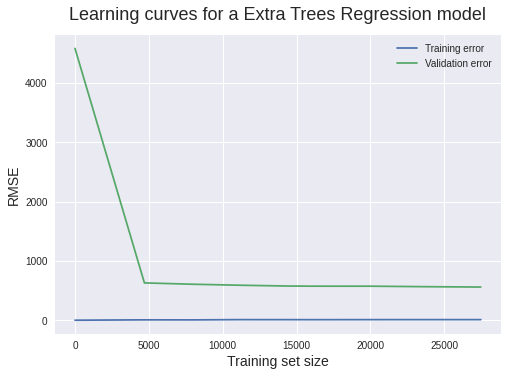

In [ ]:
# Evaluation Using learning curve
learning_plot("Extra Trees", extra_trees_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Support vector machine (SVM)

In [ ]:
# create an object the of SVR Regressor class
svr_reg_obj= SVR(C=10000, kernel='rbf')
svr_model= svr_reg_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
svr_model_mse = mean_squared_error(data_labels, svr_model.predict(data_prepared))
# compute the root of the computed mean squared error
svr_model_rmse = np.sqrt(svr_model_mse)
algorithm_results['SVM']= svr_model_rmse
svr_model_rmse

582.413351378264

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("SVR", svr_reg_obj)


  SVR Regression Cross Validation Mean Result is: 597.2898069037706
  SVR Regression Cross Validation Standard Deviation Result is: 23.933371805151708
  SVR Regression Cross Validation Score Result is:
[598.21778291 595.47480572 624.66932742 601.25503555 645.29981289
 578.18363134 592.90240436 599.4441038  586.51349367 550.93767139]


Training scores:

 [[  0.           0.           0.           0.           0.        ]
 [621.54304616 590.23777727 590.23777727 590.23777727 590.23777727]
 [614.13875522 596.51286053 593.47389531 593.47389531 593.47389531]
 [609.67412914 595.4961051  603.06366435 603.06366435 603.06366435]
 [601.80077535 589.92278418 596.89991184 596.80206937 596.80206937]
 [598.39049265 586.78087413 594.09165507 598.60343775 598.60343775]
 [593.06011611 582.64140155 587.97259026 593.71379226 593.71379226]
 [590.06341942 582.51201748 586.84118053 590.40890207 588.45463427]
 [585.27788737 579.47570469 582.98335228 585.47341591 587.43988081]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 628.57778749  668.15082655  660.95486086  638.46757339  601.33945998]
 [ 619.1720828   655.18331904  645.80557879  623.94724398  595.36431571]
 [ 612.73890842  633.38776872  629.29659714  611.46629

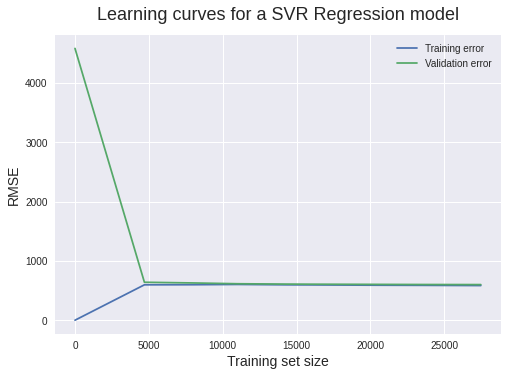

In [ ]:
# Evaluation Using learning curve
learning_plot("SVR", svr_reg_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

**Discussion Stage**\
rbf SVM perform the best of other kernels.

#### Support vector machine (NuSVR)

In [ ]:
# create an object the of NuSVR Regressor class
nu_svr_reg_obj= NuSVR(C=10000, gamma= 'scale')
nu_svr_model= nu_svr_reg_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
nu_svr_model_mse = mean_squared_error(data_labels, nu_svr_model.predict(data_prepared))
# compute the root of the computed mean squared error
nu_svr_model_rmse = np.sqrt(nu_svr_model_mse)
algorithm_results['NuSVR']= nu_svr_model_rmse
nu_svr_model_rmse

581.0828722946359

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("NuSVR", nu_svr_model)


  NuSVR Regression Cross Validation Mean Result is: 595.8828010201765
  NuSVR Regression Cross Validation Standard Deviation Result is: 23.219052744159995
  NuSVR Regression Cross Validation Score Result is:
[597.34096051 593.39745399 622.70653847 600.37396152 642.39695009
 576.95570029 591.28548316 597.87282593 585.11789124 551.38024501]


Training scores:

 [[  0.           0.           0.           0.           0.        ]
 [621.40824527 589.58032858 589.58032858 589.58032858 589.58032858]
 [612.74530304 594.80791157 593.04086219 593.04086219 593.04086219]
 [609.40217808 594.50958628 602.60444433 602.60444433 602.60444433]
 [601.75617709 589.01548302 596.16225531 596.49606445 596.49606445]
 [597.6870168  586.17930181 593.53565912 597.68901217 597.68901217]
 [590.96030962 581.99764692 587.15943421 592.80235983 592.80235983]
 [588.41708091 581.33084639 585.99197439 589.33274494 587.11473778]
 [584.06827198 578.40394459 582.33648403 584.8486596  585.99468368]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 629.3359259   667.39096015  657.04430945  635.80584021  603.10173981]
 [ 618.50417499  656.05778954  646.47705364  626.17014817  594.42192304]
 [ 613.90495935  631.97439064  628.74016276  611.17953

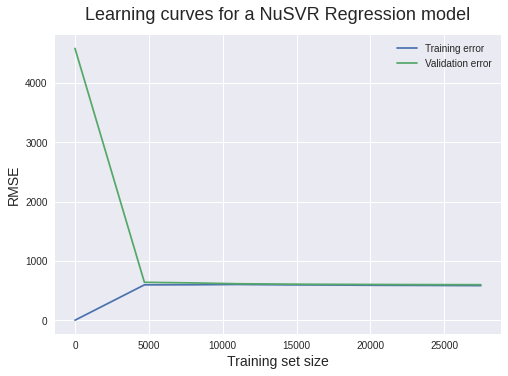

In [ ]:
# Evaluation Using learning curve
learning_plot("NuSVR", nu_svr_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Bagging Regressor

In [ ]:
# create an object the of Hist Bagging Regressor class
breg_obj = BaggingRegressor(n_estimators=750, random_state= 42, max_features= 5)
breg_model= breg_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
breg_model_mse = mean_squared_error(data_labels, breg_model.predict(data_prepared))
# compute the root of the computed mean squared error
breg_model_rmse = np.sqrt(breg_model_mse)
algorithm_results['Bagging']= breg_model_rmse
breg_model_rmse

305.9995098257542

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Bagging", breg_model)


  Bagging Regression Cross Validation Mean Result is: 813.869709408165
  Bagging Regression Cross Validation Standard Deviation Result is: 25.419244523979273
  Bagging Regression Cross Validation Score Result is:
[830.84188972 804.96734601 858.9731302  820.70187664 785.50368853
 830.75420699 789.80744966 823.58474019 825.64279767 767.91996846]


Training scores:

 [[  0.           0.           0.           0.           0.        ]
 [343.2037567  326.84077445 326.84077445 326.84077445 326.84077445]
 [324.28475304 317.74572588 319.24752868 319.24752868 319.24752868]
 [319.28101401 315.00831251 321.07326301 321.07326301 321.07326301]
 [318.52710152 312.02791284 316.07546862 315.9241816  315.9241816 ]
 [315.86068097 311.05076178 314.24749438 315.48903686 315.48903686]
 [312.05526955 308.68880072 310.59872834 312.17027057 312.17027057]
 [310.7741185  307.68360877 310.42885073 311.77515301 310.15806839]
 [307.66291849 305.02569355 307.29440572 308.39928634 309.18651535]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 888.42825246  904.40623859  874.60262462  863.23679121  861.06501298]
 [ 873.74817378  888.26279815  848.99009481  847.79582159  837.30576488]
 [ 863.82843198  869.59135798  839.25225593  834.40589

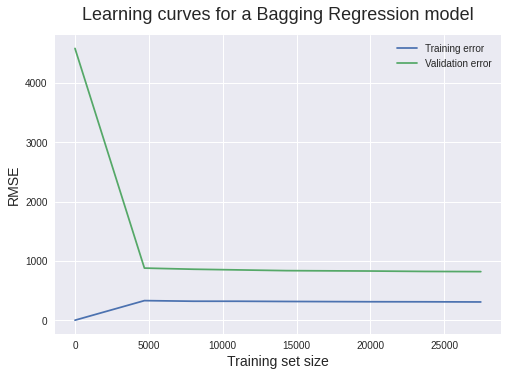

In [ ]:
# Evaluation Using learning curve
learning_plot("Bagging", breg_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Hist Gradient Boosting Regressor

In [ ]:
# create an object the of Hist Gradient Boosting Regressor class
hg_reg_obj = HistGradientBoostingRegressor(learning_rate=0.1, l2_regularization=7.6, max_iter=375, random_state= 42)
hg_reg_model= hg_reg_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
hg_reg_model_mse = mean_squared_error(data_labels, hg_reg_model.predict(data_prepared))
# compute the root of the computed mean squared error
hg_reg_model_rmse = np.sqrt(hg_reg_model_mse)
algorithm_results['Hist Gradient Boosting']= hg_reg_model_rmse
hg_reg_model_rmse

480.70155675355824

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Hist Gradient Boosting", hg_reg_model)


  Hist Gradient Boosting Regression Cross Validation Mean Result is: 561.3107382090745
  Hist Gradient Boosting Regression Cross Validation Standard Deviation Result is: 23.718772578503298
  Hist Gradient Boosting Regression Cross Validation Score Result is:
[575.2700917  562.23753326 594.23585403 556.88129456 603.97315208
 560.8032126  520.33215145 548.65862403 554.23860194 536.47686643]


Training scores:

 [[  0.           0.           0.           0.           0.        ]
 [334.08721564 288.78693988 288.78693988 288.78693988 288.78693988]
 [354.02542863 317.7191103  318.71421756 318.71421756 318.71421756]
 [463.77247861 483.12000763 467.17520836 467.17520836 467.17520836]
 [456.5803594  479.20073297 486.70715546 482.3610104  482.3610104 ]
 [478.12339733 469.33172165 452.36366533 490.58694195 490.58694195]
 [488.75217979 482.04322944 490.98282928 489.22426641 489.22426641]
 [498.5279502  497.65756193 480.96548998 508.87268668 489.61499487]
 [486.13552967 464.69989123 469.9364287  467.95092259 476.02968166]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [ 646.54005401  645.14582744  643.72357845  628.24893409  627.34567842]
 [ 632.8756276   635.10471615  613.44543516  602.46603179  591.50306528]
 [ 607.73618458  611.42645691  603.15158797  569.91579

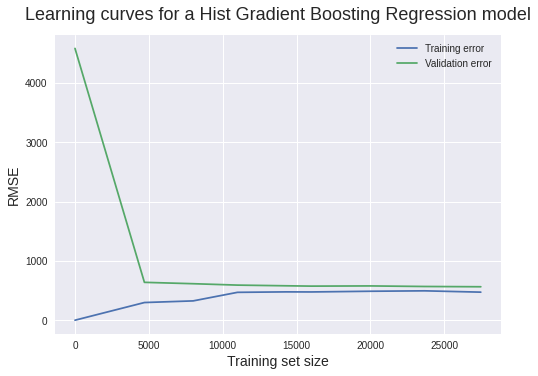

In [ ]:
# Evaluation Using learning curve
learning_plot("Hist Gradient Boosting", hg_reg_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

### Other algorithms

#### LinearRegression model

In [ ]:
# create a class object
linear_reg_obj = LinearRegression()
# train the model on the training set
poly_f = PolynomialFeatures(degree = 3) 
X_poly = poly_f.fit_transform(data_prepared) 
linear_reg_model = linear_reg_obj.fit(X_poly, data_labels)
# now evaluate LinearRegression model on the training set, Using Scikit-Learn’s root_mean_squared_error function
# compute mean squared error on the whole training set
linear_reg_mse = mean_squared_error(data_labels, linear_reg_model.predict(X_poly))
# compute the root of the computed mean square error
linear_reg_rmse = np.sqrt(linear_reg_mse)
algorithm_results['LinearRegression']= linear_reg_rmse
linear_reg_rmse

596.312429291872

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Linear", linear_reg_obj)


  Linear Regression Cross Validation Mean Result is: 1218.426322124396
  Linear Regression Cross Validation Standard Deviation Result is: 31.92685840772655
  Linear Regression Cross Validation Score Result is:
[1232.10970342 1212.64497338 1241.62748748 1260.70298427 1264.80270942
 1223.97366871 1190.6201971  1187.87146006 1212.5049269  1157.40511051]


Training scores:

 [[   0.            0.            0.            0.            0.        ]
 [1266.71417642 1223.58723292 1223.58723292 1223.58723292 1223.58723292]
 [1227.55421789 1201.77251225 1218.39419792 1218.39419792 1218.39419792]
 [1234.20872524 1216.82412889 1231.13553732 1231.13553732 1231.13553732]
 [1222.94152322 1209.42321918 1230.07281741 1226.22305217 1226.22305217]
 [1214.74989302 1202.53544295 1220.61681775 1230.46953877 1230.46953877]
 [1215.46931261 1205.76530779 1218.66319727 1228.14364634 1228.14364634]
 [1215.36354969 1207.13109917 1217.21944418 1224.75790235 1222.10120741]
 [1207.12341314 1199.95758479 1207.84124714 1215.38295388 1216.45680846]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [1224.24201887 1252.86707013 1264.43197527 1188.37298595 1181.03206994]
 [1220.06147276 1254.92887968 1274.20172673 1187.28506063 1179.45668958]
 [1224.67

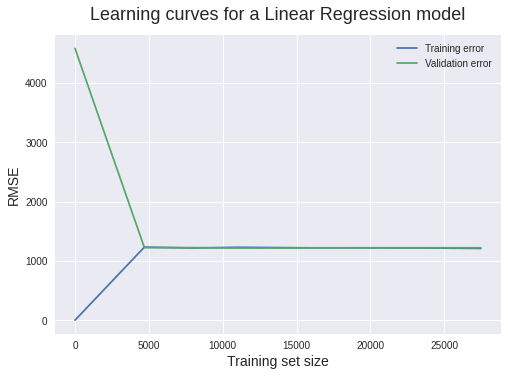

In [ ]:
# Evaluation Using learning curve
learning_plot("Linear", linear_reg_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Lasso Regressor

In [ ]:
# create an object the of Lasso class
lasso_obj = Lasso(tol= 1.904e+07, alpha=0.0001, random_state= 42)
lasso_model= lasso_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
lasso_mse = mean_squared_error(data_labels, lasso_model.predict(data_prepared))
# compute the root of the computed mean squared error
lasso_rmse = np.sqrt(lasso_mse)
algorithm_results['Lasso']= lasso_rmse
lasso_rmse

1313.020073057188

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Lasso", lasso_obj)


  Lasso Regression Cross Validation Mean Result is: 1312.9987343960474
  Lasso Regression Cross Validation Standard Deviation Result is: 25.450579552996018
  Lasso Regression Cross Validation Score Result is:
[1325.47583148 1312.778756   1354.59475878 1337.49501232 1284.33917917
 1319.14435227 1287.97686821 1316.02236136 1327.09980263 1265.06042175]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Training scores:

 [[   0.            0.            0.            0.            0.        ]
 [1368.56769012 1337.92443969 1337.92443969 1337.92443969 1337.92443969]
 [1334.60412157 1316.55448169 1329.95635833 1329.95635833 1329.95635833]
 [1328.94958342 1315.58661237 1337.70984321 1337.70984321 1337.70984321]
 [1320.90326251 1310.56146742 1335.23897535 1333.08346526 1333.08346526]
 [1312.98633408 1303.70265835 1325.86950307 1332.35775249 1332.35775249]
 [1314.83003116 1307.47737848 1325.00481903 1328.34903327 1328.34903327]
 [1315.04302848 1308.8776345  1323.84433576 1325.12754518 1321.80216892]
 [1309.05428805 1303.70224048 1316.64087775 1317.79965249 1317.77141839]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [1337.31051387 1361.5998233  1319.10012829 1318.2476658  1313.30620463]
 [1321.31292586 1351.51367774 1311.32556921 1310.68215643 1305.58905915]
 [1323.18

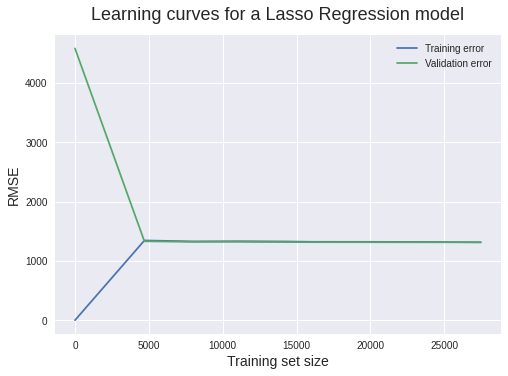

In [ ]:
# Evaluation Using learning curve
learning_plot("Lasso", lasso_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Ridge Regressor

In [ ]:
# create an object the of Ridge class
ridge_obj= Ridge(random_state= 42)
ridge_model= ridge_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
ridge_mse = mean_squared_error(data_labels, ridge_model.predict(data_prepared))
# compute the root of the computed mean squared error
ridge_rmse = np.sqrt(ridge_mse)
algorithm_results['Ridge']= ridge_rmse
ridge_rmse

1210.1340760661526

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Ridge", ridge_obj)


  Ridge Regression Cross Validation Mean Result is: 1218.1819087475828
  Ridge Regression Cross Validation Standard Deviation Result is: 31.613466539047224
  Ridge Regression Cross Validation Score Result is:
[1231.97377428 1212.63849409 1241.44303026 1260.87768476 1262.45590694
 1224.14156289 1190.61429304 1187.87446876 1212.46404752 1157.33582493]


Training scores:

 [[   0.            0.            0.            0.            0.        ]
 [1266.88008741 1223.66430055 1223.66430055 1223.66430055 1223.66430055]
 [1227.60133097 1201.81864124 1218.43738395 1218.43738395 1218.43738395]
 [1234.22491003 1216.84212776 1231.15996251 1231.15996251 1231.15996251]
 [1222.95491613 1209.43874909 1230.08666619 1226.23544551 1226.23544551]
 [1214.76063936 1202.54741319 1220.62767244 1230.47237935 1230.47237935]
 [1215.47661418 1205.77326058 1218.67090389 1228.14938461 1228.14938461]
 [1215.36816581 1207.13540448 1217.22580904 1224.76209694 1222.10577006]
 [1207.12671378 1199.96063126 1207.84543263 1215.38597558 1216.46002787]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [1223.8232484  1252.2697528  1254.37982289 1188.88560661 1181.47403439]
 [1219.84847751 1253.85785249 1264.6562086  1187.41422657 1179.56322918]
 [1224.56

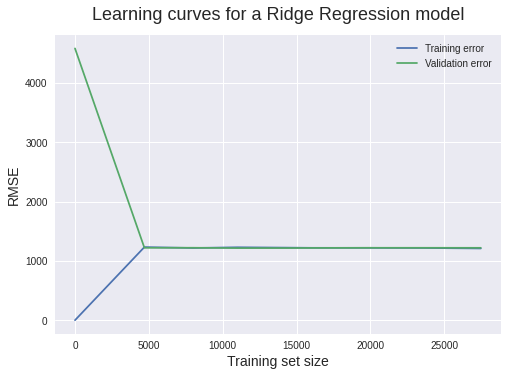

In [ ]:
# Evaluation Using learning curve
learning_plot("Ridge", ridge_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

 #### AdaBoost Regressor

In [ ]:
# create an object the of Ada Boost Regressor class
adb_obj = AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=.1, loss="linear", random_state= 42)
adb_model= adb_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
adb_model_mse = mean_squared_error(data_labels, adb_obj.predict(data_prepared))
# compute the root of the computed mean squared error
adb_model_rmse = np.sqrt(adb_model_mse)
algorithm_results['AdaBoost ']= adb_model_rmse
adb_model_rmse

1148.9209946434644

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("AdaBoost", adb_model)


  AdaBoost Regression Cross Validation Mean Result is: 1162.6781880595454
  AdaBoost Regression Cross Validation Standard Deviation Result is: 22.261354200366753
  AdaBoost Regression Cross Validation Score Result is:
[1151.05632394 1169.85715763 1177.94185813 1180.79979682 1133.78927003
 1189.88953897 1123.86493788 1177.76686096 1182.02998753 1139.78614872]


Training scores:

 [[   0.            0.            0.            0.            0.        ]
 [1173.67011312 1106.62589485 1106.62589485 1106.62589485 1106.62589485]
 [1157.93102676 1092.94763981 1106.80769892 1106.80769892 1106.80769892]
 [1155.03197116 1100.70832348 1115.93357465 1115.93357465 1115.93357465]
 [1160.35356428 1114.6438687  1133.2612594  1143.97698952 1143.97698952]
 [1172.8973479  1117.12234422 1144.79431728 1138.12988435 1138.12988435]
 [1163.3037128  1147.49934774 1153.88932789 1134.70647199 1134.70647199]
 [1178.22730101 1152.98643571 1158.16309527 1158.96627033 1155.99250219]
 [1178.14245375 1136.53832583 1156.85377351 1140.39622533 1148.49152634]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [1171.84344056 1156.75272811 1147.02894276 1146.8190113  1136.93972229]
 [1167.93484224 1142.10669164 1146.55938847 1144.3717985  1134.40593584]
 [1168.98

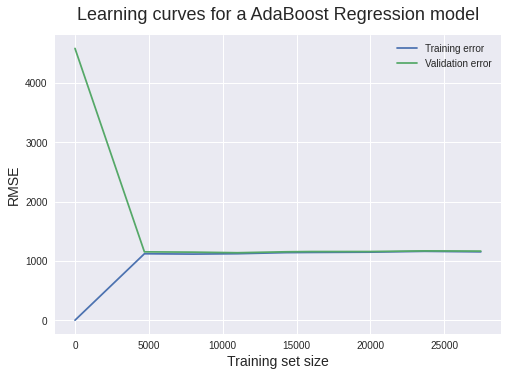

In [ ]:
# Evaluation Using learning curve
learning_plot("AdaBoost", adb_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### SGD Regressor

In [ ]:
# create an object the of SGD class
sgd_obj= SGDRegressor(random_state= 42)
sgd_model= sgd_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
sgd_mse = mean_squared_error(data_labels, sgd_obj.predict(data_prepared))
# compute the root of the computed mean squared error
sgd_rmse = np.sqrt(sgd_mse)
algorithm_results['SGD']= sgd_rmse
sgd_rmse

1214.9249758768378

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("SGD", sgd_obj)


  SGD Regression Cross Validation Mean Result is: 1221.2248090701294
  SGD Regression Cross Validation Standard Deviation Result is: 24.288451981436296
  SGD Regression Cross Validation Score Result is:
[1234.78823549 1220.8890851  1239.83951846 1268.28710552 1215.37014877
 1239.32279817 1191.81629443 1206.76029583 1214.91477133 1180.2598376 ]


Training scores:

 [[1.41711540e-02 1.61730481e-02 1.61730481e-02 1.61730481e-02
  1.61730481e-02]
 [1.28402493e+03 1.22816159e+03 1.22816159e+03 1.22816159e+03
  1.22816159e+03]
 [1.23813536e+03 1.23166873e+03 1.22748522e+03 1.22748522e+03
  1.22748522e+03]
 [1.24042540e+03 1.22859674e+03 1.23706504e+03 1.23706504e+03
  1.23706504e+03]
 [1.24433377e+03 1.22270366e+03 1.24386924e+03 1.24186379e+03
  1.24186379e+03]
 [1.22142573e+03 1.21330162e+03 1.24369438e+03 1.24402495e+03
  1.24402495e+03]
 [1.22217956e+03 1.20948576e+03 1.24562659e+03 1.23548209e+03
  1.23548209e+03]
 [1.22846873e+03 1.21322551e+03 1.22044801e+03 1.22900587e+03
  1.22888549e+03]
 [1.21281192e+03 1.20916277e+03 1.21261807e+03 1.21893508e+03
  1.23429918e+03]]

 ----------------------------------------------------------------------

Validation scores:

 [[5261.1960068  5009.91135144 4920.32907952 4851.14100507 4984.7848859 ]
 [1240.45001622 1254.66915143 1219.67086585 1193.31018524 1186.55976875]
 [1228.50193539 127

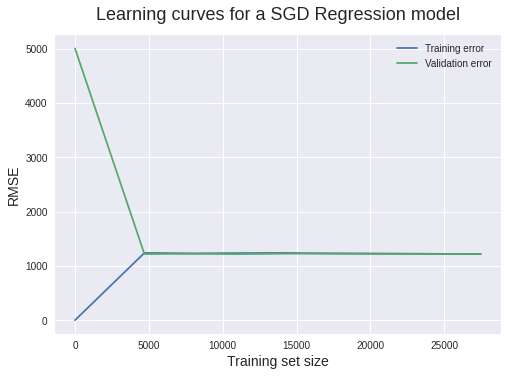

In [ ]:
# Evaluation Using learning curve
learning_plot("SGD", sgd_obj, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Tweedie Regressor

In [ ]:
# create an object the of Tweedie Regressor class
twdi_obj = TweedieRegressor(alpha=0.1, max_iter=10000)
twdi_model= twdi_obj.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
twdi_model_mse = mean_squared_error(data_labels, twdi_model.predict(data_prepared))
# compute the root of the computed mean squared error
twdi_model_rmse = np.sqrt(twdi_model_mse)
algorithm_results['Tweedie']= twdi_model_rmse
twdi_model_rmse

1313.3365794633949

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("Tweedie", twdi_model)


  Tweedie Regression Cross Validation Mean Result is: 1313.5215222462618
  Tweedie Regression Cross Validation Standard Deviation Result is: 22.201925037782154
  Tweedie Regression Cross Validation Score Result is:
[1311.41897913 1319.86315091 1351.93791546 1333.58789924 1299.14634514
 1313.1429646  1294.12336324 1318.6323007  1326.92801357 1266.43429046]


Training scores:

 [[   0.            0.            0.            0.            0.        ]
 [1352.33893524 1318.40838089 1318.40838089 1318.40838089 1318.40838089]
 [1329.69584402 1307.42805733 1317.61182523 1317.61182523 1317.61182523]
 [1331.33451413 1315.03298626 1328.28405249 1328.28405249 1328.28405249]
 [1323.83844696 1311.11153914 1328.54672776 1326.15149344 1326.15149344]
 [1318.37515718 1306.95480645 1322.53231006 1326.75023501 1326.75023501]
 [1319.16975553 1310.08562273 1322.32236434 1325.78628157 1325.78628157]
 [1319.32585301 1311.70832917 1322.08516722 1323.60961572 1320.85253839]
 [1312.12087734 1305.52684719 1314.45008779 1315.89043495 1318.40968885]]

 ----------------------------------------------------------------------

Validation scores:

 [[4961.56762061 4552.09376951 4465.65163344 4401.99471318 4521.64326307]
 [1321.70286441 1346.42836515 1310.58564858 1311.12722145 1301.61338166]
 [1315.63408716 1343.03692514 1307.74527486 1307.98670314 1298.33058519]
 [1319.53

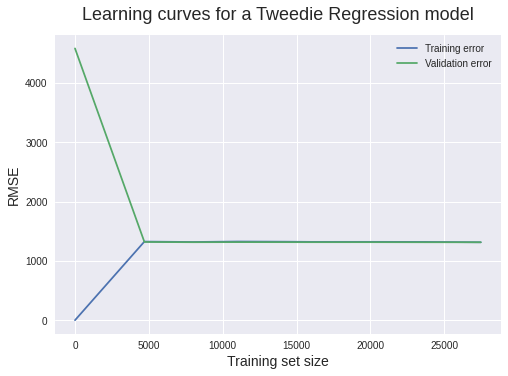

In [ ]:
# Evaluation Using learning curve
learning_plot("Tweedie", twdi_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### PLS Regression

In [ ]:
# create an object the of PLS Regressor class
pls = PLSRegression()
pls_model= pls.fit(data_prepared, data_labels)
# compute mean squared error on the whole training set
pls_model_mse = mean_squared_error(data_labels, pls_model.predict(data_prepared))
# compute the root of the computed mean squared error
pls_model_rmse = np.sqrt(pls_model_mse)
algorithm_results['PLS']= pls_model_rmse
pls_model_rmse

1432.3399007513085

**Testing whether or not there is an overfit problem**

In [ ]:
# Evaluation Using Cross-Validation
cross_val("PLS", pls_model)


  PLS Regression Cross Validation Mean Result is: 1432.4471085692635
  PLS Regression Cross Validation Standard Deviation Result is: 21.877963008158975
  PLS Regression Cross Validation Score Result is:
[1426.49597663 1437.83329345 1468.65003212 1431.1632161  1434.76489708
 1437.00040222 1415.5513391  1437.27016338 1454.27115352 1381.47061209]


Training scores:

 [[          nan           nan           nan           nan           nan]
 [1463.32049478 1436.56846535 1436.56846535 1436.56846535 1436.56846535]
 [1449.26851347 1429.31835016 1437.21412059 1437.21412059 1437.21412059]
 [1444.7773121  1429.90915671 1447.76638326 1447.76638326 1447.76638326]
 [1439.5646164  1428.1134558  1445.53418342 1444.33792913 1444.33792913]
 [1434.4560217  1424.15810365 1439.79848074 1444.41540104 1444.41540104]
 [1435.8794117  1427.68927473 1440.0887138  1441.16377261 1441.16377261]
 [1436.79441299 1429.93449198 1440.46458471 1440.30291022 1437.40389061]
 [1431.37578649 1425.45192917 1434.54326073 1434.45873662 1435.69134384]]

 ----------------------------------------------------------------------

Validation scores:

 [[          nan           nan           nan           nan           nan]
 [1443.11203602 1456.48669372 1441.67161618 1432.58031057 1424.73369253]
 [1439.39419395 1452.74550767 1439.97850812 1430.8047857  1423.3166823 ]
 [1433.82

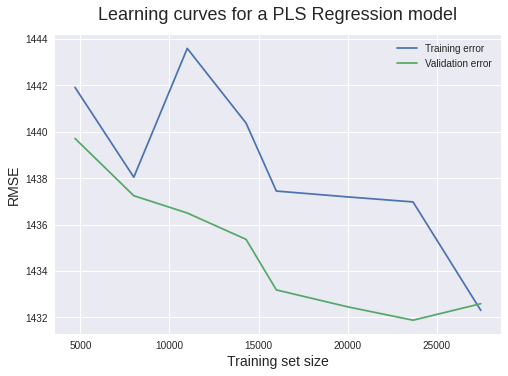

In [ ]:
# Evaluation Using learning curve
learning_plot("PLS", pls_model, X= data_prepared, y= data_labels, scoring= 'neg_mean_squared_error', cv= 10)

#### Now it's time to see the variety of algorithm results is a graph

In [ ]:
results_dataframe= pd.DataFrame(algorithm_results.items(), columns= ['Algorithms', 'Algorithm_Results'])
results_dataframe

,Algorithms,Algorithm_Results
0,DecisionTree,10.195672
1,RandomForest,204.512275
2,GrandientBoosting,493.545477
3,XGB,486.417666
4,Extra Trees,10.196434
5,KNN,10.195672
6,SVM,582.413351
7,NuSVR,581.082872
8,Bagging,305.999510
9,Hist Gradient Boosting,480.701557


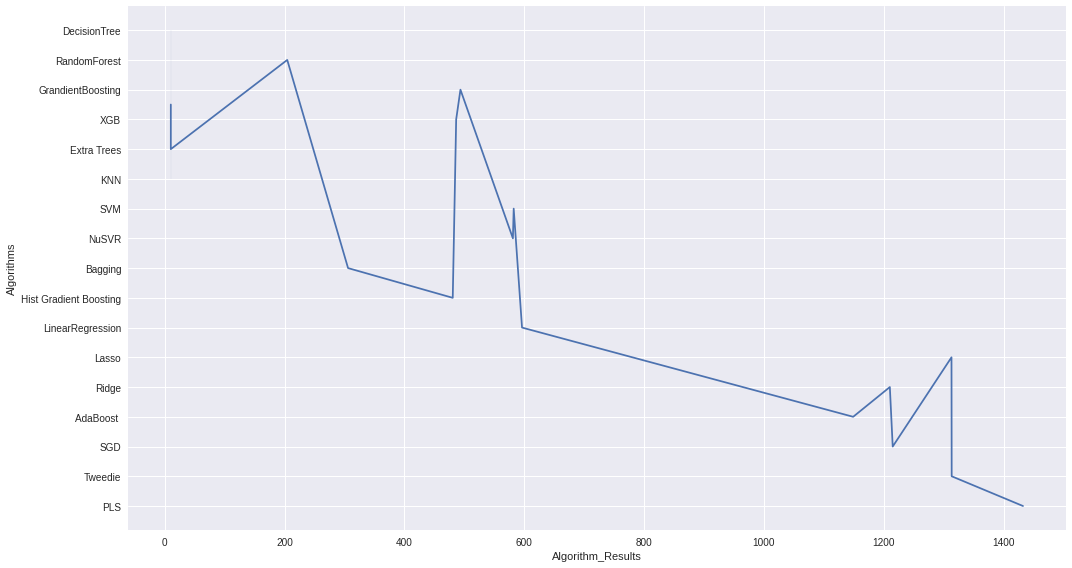

In [ ]:
# visualizing the training Scores of all the models
plt.figure(figsize= (15, 8)) 
sns.lineplot(y= results_dataframe['Algorithms'], x= results_dataframe['Algorithm_Results'], dashes=False, markers=True)
plt.yticks(range(len(results_dataframe['Algorithms'])))
plt.tight_layout()
plt.show()

#### Evaluate the model on stratified test set by best estimator

In [ ]:
# check the test set
test_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Very Good,E,SI1,62.9,58.0,6324,6.78,6.79,4.27
1,0.71,Ideal,D,SI2,62.0,54.0,2934,5.77,5.74,3.57
2,1.52,Premium,H,SI1,60.1,60.0,9959,7.45,7.39,4.46
3,1.57,Ideal,E,SI2,61.4,56.0,10362,7.44,7.52,4.59
4,0.30,Premium,G,VS1,61.4,60.0,605,4.30,4.33,2.65


In [ ]:
testing_data= test_data.drop(["price"], axis= 1)
test_data_labels= test_data['price'].copy()

In [ ]:
# apply other transfomers to the test set
test_data_prepared= full_pipeline.transform(test_data)
test_data_prepared.shape

(8608, 9)

In [ ]:
# for test simplicity I will use a variable to determine the best algorithm in my opinion
algorithm_dict= {'Decision Tree': tree_reg_model, 'Random Forest': forest_model, 'Grandient Boosting': grad_boosting_model, 'XGB': XGB_model,
                 'Extra Trees': extra_trees_model, 'KNN': knn_model, 'SVR' :svr_model, 'NuSVR': nu_svr_model, 'Bagging': breg_model, 'Hist Gradient Boosting': hg_reg_model,
                 'Lasso': lasso_model, 'Ridge': ridge_model, 'Ada Boost': adb_model, 'SGD': sgd_model, 'Tweedie': twdi_model, 'PLS': pls_model}
# compute mean squared error on the whole training set
for name, model in algorithm_dict.items():
  test_mse = mean_squared_error(test_data_labels, model.predict(test_data_prepared))
  # compute the root of the computed mean squared error
  test_rmse = np.sqrt(test_mse)
  print(f"The predicted result of {name} Regression through testing is: {test_rmse}")
# for polynomial regression predict purpose I will use split transform of it
poly_test_prepared= poly_f.transform(test_data_prepared)
test_mse = mean_squared_error(test_data_labels, linear_reg_model.predict(poly_test_prepared))
# compute the root of the computed mean squared error
test_rmse = np.sqrt(test_mse)
print(f"The predicted result of Linear Regression through testing with poly is: {test_rmse}")

The predicted result of Decision Tree Regression through testing is: 742.4490009967602
The predicted result of Random Forest Regression through testing is: 538.4945951553382
The predicted result of Grandient Boosting Regression through testing is: 557.67952690397
The predicted result of XGB Regression through testing is: 553.8379387654021
The predicted result of Extra Trees Regression through testing is: 536.1145372197345
The predicted result of KNN Regression through testing is: 625.9403433789307
The predicted result of SVR Regression through testing is: 592.9158367000546
The predicted result of NuSVR Regression through testing is: 591.8283039059114
The predicted result of Bagging Regression through testing is: 778.3045918701806
The predicted result of Hist Gradient Boosting Regression through testing is: 529.2410038145869
The predicted result of Lasso Regression through testing is: 1302.4082618566706
The predicted result of Ridge Regression through testing is: 1199.0941988393022
The 

#### Analyze the Best Models and Their Errors

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


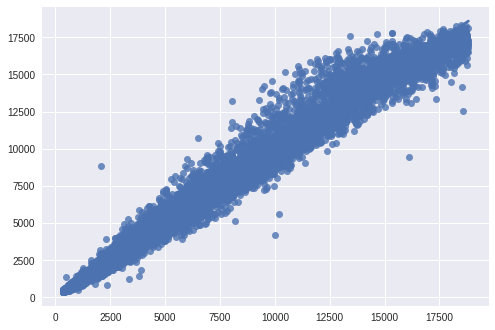

In [ ]:
# predicted result on training data
plt.figure()
sns.regplot(data_labels, hg_reg_model.predict(data_prepared),fit_reg= True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


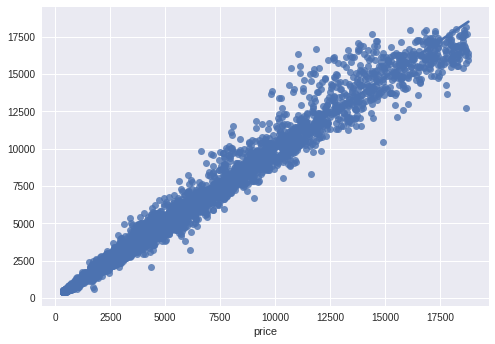

In [ ]:
# predicted result on testing data
plt.figure()
sns.regplot(test_data_labels, hg_reg_model.predict(test_data_prepared),fit_reg= True)
plt.show()

In [ ]:
# check important features of the best model
# because of the best model in this situation "hg_reg_model" did not have feature_importances_ attribute I will use a second best parameter to perform analysis.
feature_importances = extra_trees_model.feature_importances_
sorted(zip(feature_importances, data_prepared_df.columns), reverse=True)

[(0.23412709581268062, 'carat'),
 (0.22189209086843464, 'x'),
 (0.17824412487380667, 'size'),
 (0.1706241979518155, 'y'),
 (0.09632826445945135, 'z'),
 (0.05954035809561897, 'clarity'),
 (0.03153046019196094, 'color'),
 (0.00440216236946017, 'cut'),
 (0.0033112453767712244, 'table')]

Now it's time to manipulate with hyperparameters, maybe we get better evaluation.

# Fine Tune the model

### Grid search

First I will define a function to help us with the visualization of the model results.

In [35]:
def params_results(seach_obj):
  '''
  Returns dataframe of the best parameters search results.
  Args:
  search_obj-- object of the final search results.
  Returns:
  Return:
  dataframe of the best estimator and print it
  '''
  # get grid search results as a data frame
  cv_res= pd.DataFrame(seach_obj.cv_results_)
  # sorting values by mean test score
  cv_res.sort_values(by="mean_test_score", ascending=True, inplace=True)
  # select only the needed columns that I want to evaluate the model by them
  cv_res_df= cv_res[['mean_test_score']].copy()
  cv_res_df['mean_test_score']= cv_res_df['mean_test_score'].apply(lambda number: np.sqrt(-number))
  # extract dictionary values in params key and place it in new columns in the data frame for better understand of it
  cv_res_df= pd.concat([cv_res_df, pd.DataFrame(list(cv_res['params']))], axis=1)
  # reset index in the data frame
  cv_res_df.reset_index(drop= True, inplace= True)
  return cv_res_df

#### Random forest Grid search 

In [ ]:
params= [
  {'n_estimators': [170, 500, 630], 'max_features':[5, 7, 9]},
  {'bootstrap': [False], 'n_estimators': [80, 130, 360], 'max_features':[5, 6, 8]}
  ]
# create instance of GridSearchCV and initialize it
cv_test= KFold(n_splits=5)
forest_grid_search= GridSearchCV(estimator= RandomForestRegressor(),
                          param_grid= params, cv= cv_test, scoring='neg_mean_squared_error',
                          return_train_score=True)
# fit the model on the training set and evaluate it by grid search 
forest_grid_search_model= forest_grid_search.fit(data_prepared, data_labels)

In [ ]:
# return dataframe of the best parameters search results
print(params_results(forest_grid_search_model))

    mean_test_score bootstrap  max_features  n_estimators
0        569.805737     False             8            80
1        567.746763     False             8           130
2        567.602009     False             8           360
3        571.488933     False             6            80
4        570.550465     False             6           130
5        570.327447     False             6           360
6        576.248135     False             5            80
7        575.048193     False             5           130
8        575.268232     False             5           360
9        589.448683       NaN             9           170
10       587.609638       NaN             9           630
11       585.585141       NaN             9           500
12       600.112072       NaN             7           170
13       599.021205       NaN             7           500
14       597.243472       NaN             7           630
15       647.459967       NaN             5           170
16       647.1

In [ ]:
forest_grid= forest_grid_search_model.best_estimator_
forest_grid

RandomForestRegressor(max_features=5, n_estimators=630)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Random Forest ", forest_grid)


  Random Forest  Regression Cross Validation Mean Result is: 560.2580445563211
  Random Forest  Regression Cross Validation Standard Deviation Result is: 19.1620121316187
  Random Forest  Regression Cross Validation Score Result is:
[583.24178297 563.81925458 589.66200959 550.7521754  583.33005594
 557.18934651 549.20793878 539.23049196 558.55492168 527.59246815]


#### KNN Grid Search

In [ ]:
params= [
    {"n_neighbors": [4, 20, 37, 43, 59, 67, 71, 84, 92, 108], "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'], "p" : [1, 2]}
    ]
# create instance of GridSearchCV and initialize it
cv_test= KFold(n_splits=5)
knn_grid_search= GridSearchCV(estimator= KNeighborsRegressor(),
                          param_grid= params, cv= cv_test, scoring='neg_mean_squared_error',
                          return_train_score=True)
# fit the model on the training set and evaluate it by grid search 
knn_grid_search_model= knn_grid_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(knn_grid_search_model))

In [ ]:
# get best estimator of the model
knn_grid= knn_grid_search.best_estimator_
knn_grid

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("KNN ", knn_grid)

#### Gradient Boosting Grid Search

In [ ]:
params= [{'learning_rate': [0.1], 'n_estimators': [700, 900], 'loss': ['absolute_error'], 'max_features':[5, 7, 9]},
         {'learning_rate': [0.05], 'n_estimators': [300, 400, 600], 'loss': ['squared_error'], 'max_features':[5, 9]}]
# create instance of GridSearchCV and initialize it
cv_test= KFold(n_splits=5)
grad_boosting_grid_search= GridSearchCV(estimator= GradientBoostingRegressor(),
                          param_grid= params, cv= cv_test, scoring='neg_mean_squared_error',
                          return_train_score=True)
# fit the model on the training set and evaluate it by grid search 
gb_grid_search_model= grad_boosting_grid_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(gb_grid_search_model))

    mean_test_score  learning_rate            loss  max_features  n_estimators
0        614.633553           0.10  absolute_error             5           700
1        613.491554           0.10  absolute_error             5           900
2        608.433167           0.05   squared_error             9           300
3        607.312975           0.05   squared_error             5           300
4        603.815826           0.10  absolute_error             7           700
5        605.608921           0.10  absolute_error             7           900
6        611.086014           0.10  absolute_error             9           900
7        603.850580           0.05   squared_error             5           400
8        589.048976           0.10  absolute_error             9           700
9        613.199197           0.05   squared_error             9           400
10       601.520853           0.05   squared_error             5           600
11       587.972005           0.05   squared_error  

In [ ]:
# get best estimator of the model
gb_grid_search_res= gb_grid_search_model.best_estimator_
gb_grid_search_res

GradientBoostingRegressor(learning_rate=0.05, max_features=9, n_estimators=600)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Gradient Boosting ", gb_grid_search_res)


  Gradient Boosting  Regression Cross Validation Mean Result is: 585.9761255609317
  Gradient Boosting  Regression Cross Validation Standard Deviation Result is: 28.788636081043588
  Gradient Boosting  Regression Cross Validation Score Result is:
[595.66480352 584.23380482 621.32926375 575.19758036 648.93990821
 574.62190238 557.29256457 563.89373048 590.08562869 548.50206885]


**Here above, I tested Grid Search on default random state for testing on a variety state condition after I had tested it using random state of 42**

#### XGBooting Grid Search

In [ ]:
params= [{'learning_rate': [0.05, 0.01], 'n_estimators': [220, 270, 300, 360, 400]}]
# create instance of GridSearchCV and initialize it
cv_test= KFold(n_splits=5)
x_grad_boosting_grid_search= GridSearchCV(estimator= xgb.XGBRegressor(objective ='reg:squarederror', random_state= 42),
                          param_grid= params, cv= cv_test, scoring='neg_mean_squared_error',
                          return_train_score=True)
# fit the model on the training set and evaluate it by grid search 
xgb_grid_search_model= x_grad_boosting_grid_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(xgb_grid_search_model))

   mean_test_score  learning_rate  n_estimators
0       629.484755           0.01           220
1       618.842779           0.01           270
2       614.256589           0.01           300
3       606.591830           0.01           360
4       602.655449           0.01           400
5      1166.168274           0.05           220
6      1001.044929           0.05           270
7       936.030417           0.05           300
8       851.620391           0.05           360
9       810.170778           0.05           400


In [ ]:
# get best estimator of the model
xgb_grid_search_res= xgb_grid_search_model.best_estimator_
xgb_grid_search_res

XGBRegressor(learning_rate=0.05, n_estimators=400, objective='reg:squarederror',
             random_state=42)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Gradient Boosting ", xgb_grid_search_res)


  Gradient Boosting  Regression Cross Validation Mean Result is: 600.0581097597635
  Gradient Boosting  Regression Cross Validation Standard Deviation Result is: 26.260988397349045
  Gradient Boosting  Regression Cross Validation Score Result is:
[611.19183238 607.62166493 633.25950136 591.60587063 652.01009217
 590.05085713 572.91406368 580.75805039 601.49598577 559.67317914]


#### Extra Trees Regressor Grid Search

In [ ]:
params= [{'n_estimators': [80, 230, 460, 830], 'max_features':[5, 7, 9]}]
# create instance of GridSearchCV and initialize it
cv_test= KFold(n_splits=5)
extra_trees_grid_search= GridSearchCV(estimator= ExtraTreesRegressor(random_state= 42),
                          param_grid= params, cv= cv_test, scoring='neg_mean_squared_error',
                          return_train_score=True)
# fit the model on the training set and evaluate it by grid search 
extra_trees_grid_search_model= extra_trees_grid_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(extra_trees_grid_search_model))

    mean_test_score  max_features  n_estimators
0        561.909238             9            80
1        560.115467             7            80
2        559.125901             9           230
3        558.419454             9           460
4        566.653379             9           830
5        562.661988             7           230
6        561.811490             5            80
7        561.361750             7           460
8        567.302997             7           830
9        565.114679             5           230
10       564.762250             5           460
11       564.448546             5           830


In [ ]:
# get best estimator of the model
extra_trees_grid_search_res= extra_trees_grid_search_model.best_estimator_
extra_trees_grid_search_res

ExtraTreesRegressor(max_features=5, n_estimators=830, random_state=42)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Extra Trees", extra_trees_grid_search_res)


  Extra Trees Regression Cross Validation Mean Result is: 550.9020848475983
  Extra Trees Regression Cross Validation Standard Deviation Result is: 18.302830011366655
  Extra Trees Regression Cross Validation Score Result is:
[576.67652596 546.98740939 584.1579472  542.61422353 563.2855257
 546.48808877 541.59696437 535.9833366  552.14260942 519.08821753]


#### Hist Gradient Boosting Regressor Grid Search

In [38]:
params= [{'learning_rate': [0.1], 'l2_regularization':[1, 3, 6, 7], 'max_iter': [100, 200, 300]},
         {'learning_rate': [0.05], 'l2_regularization':[2, 4, 7, 8.5], 'max_iter': [130, 240, 300]}]
# create instance of GridSearchCV and initialize it
cv_test= KFold(n_splits=5)
hg_reg_grid_search= GridSearchCV(estimator= HistGradientBoostingRegressor(random_state= 42),
                          param_grid= params, cv= cv_test, scoring='neg_mean_squared_error',
                          return_train_score=True)
# fit the model on the training set and evaluate it by grid search 
hg_reg_grid_search_model= hg_reg_grid_search.fit(data_prepared, data_labels)

In [39]:
# Return dataframe of the best parameters search results.
print(params_results(hg_reg_grid_search_model))

    mean_test_score  l2_regularization  learning_rate  max_iter
0        563.509604                7.0           0.05       130
1        563.203562                8.5           0.05       130
2        563.203562                7.0           0.10       100
3        564.320420                4.0           0.05       130
4        564.016764                7.0           0.10       300
5        564.016764                7.0           0.10       200
6        565.065718                2.0           0.05       130
7        564.413677                6.0           0.10       100
8        564.413677                6.0           0.10       200
9        567.524339                6.0           0.10       300
10       567.111206                3.0           0.10       100
11       567.111206                3.0           0.10       200
12       567.033861                3.0           0.10       300
13       562.448245                1.0           0.10       100
14       562.448245                1.0  

In [40]:
# get best estimator of the model
hg_reg_grid_search_res= hg_reg_grid_search_model.best_estimator_
hg_reg_grid_search_res

HistGradientBoostingRegressor(l2_regularization=8.5, learning_rate=0.05,
                              max_iter=300, random_state=42)

In [41]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Hist Gradient Boosting", hg_reg_grid_search_res)


  Hist Gradient Boosting Regression Cross Validation Mean Result is: 560.4346091102386
  Hist Gradient Boosting Regression Cross Validation Standard Deviation Result is: 22.762990868211713
  Hist Gradient Boosting Regression Cross Validation Score Result is:
[578.08396529 562.42246652 595.22629305 558.30173021 597.41478943
 559.51407175 525.87910704 544.67478096 549.05336683 533.77552003]


### Random Search

#### Random Forest Random Search

In [ ]:
param_distribs = {
        'n_estimators': np.random.randint(1, 300, 7),
        'max_features': np.random.randint(5, 9, 2),
    }
cv_test= KFold(n_splits=5)
# create instance of RandomSearchCV and initialize it
forest_rnd_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_distribs,
                                n_iter=5, cv=cv_test, scoring='neg_mean_squared_error', random_state=42)
# fit the model on the training set and evaluate it by random search 
forest_rnd_search_model= forest_rnd_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(forest_rnd_search_model))

   mean_test_score  n_estimators  max_features
0       642.131914             4             8
1       580.680585            47             8
2       574.452970           131             8
3       572.991639           189             8
4       574.120628           189             8


In [ ]:
# get best estimator of the model
forest_random_search_res= forest_rnd_search_model.best_estimator_
forest_random_search_res

RandomForestRegressor(max_features=8, n_estimators=189)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Random Forest", forest_random_search_res)


  Random Forest Regression Cross Validation Mean Result is: 565.8740787584369
  Random Forest Regression Cross Validation Standard Deviation Result is: 23.168822577881247
  Random Forest Regression Cross Validation Score Result is:
[580.96356206 571.67341515 595.27913349 555.75077575 611.65169436
 558.2738628  548.10007138 541.75081263 562.20813801 533.08932196]


#### Gradient Boosting Random Search

In [ ]:
param_distribs = {
        'learning_rate': [0.1, 0.04],
        'n_estimators': np.random.randint(1, 200, 10),
        'max_features': np.random.randint(5, 9, 2),
    }
# create instance of RandomSearchCV and initialize it
grad_boosting_ran_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
# fit the model on the training set and evaluate it by random search 
grad_boosting_rnd_search_model= grad_boosting_ran_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(grad_boosting_rnd_search_model))

   mean_test_score  n_estimators  max_features  learning_rate
0       640.268107            24             5           0.10
1       650.506337            29             5           0.10
2      1052.466018            91             5           0.04
3       868.908422           100             5           0.04
4       610.162829           124             5           0.04
5       954.297509           124             5           0.04
6       760.651260            91             5           0.10
7       758.413325            91             5           0.10
8       829.172318           100             5           0.10
9       648.813980           187             5           0.10


In [ ]:
# get best estimator of the model
gb_random_search_res= grad_boosting_rnd_search_model.best_estimator_
gb_random_search_res

GradientBoostingRegressor(max_features=5, n_estimators=187)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Gradient Boosting", gb_random_search_res)


  Gradient Boosting Regression Cross Validation Mean Result is: 605.5224874148657
  Gradient Boosting Regression Cross Validation Standard Deviation Result is: 22.078501639613986
  Gradient Boosting Regression Cross Validation Score Result is:
[609.99459191 622.54726893 639.5229328  603.00724578 631.28969324
 605.93562773 586.99321605 592.28330529 605.2410734  558.40991902]


#### XGBoosting Random Search

In [ ]:
param_distribs = {
        'learning_rate': [0.1, 0.04],
        'n_estimators': np.random.randint(1, 200, 10),
        'max_features': np.random.randint(5, 9, 2),
    }
# create instance of RandomSearchCV and initialize it
xgrad_boosting_ran_search = RandomizedSearchCV(xgb.XGBRegressor(objective ='reg:squarederror', random_state= 42), param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
# fit the model on the training set and evaluate it by random search 
xgrad_boosting_rnd_search_model= xgrad_boosting_ran_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(xgrad_boosting_rnd_search_model))

   mean_test_score  n_estimators  max_features  learning_rate
0       650.502579            15             6           0.10
1       632.284812            64             6           0.04
2       620.448984            64             7           0.04
3       779.877542            85             6           0.04
4       750.054721           108             7           0.04
5      1595.975394            47             7           0.10
6      1030.207205            85             6           0.10
7      1030.207205           108             6           0.10
8       870.597589           108             7           0.10
9       632.284812           130             6           0.10


In [ ]:
# get best estimator of the model
xgb_random_search_res= xgrad_boosting_rnd_search_model.best_estimator_
xgb_random_search_res

XGBRegressor(max_features=6, n_estimators=130, objective='reg:squarederror',
             random_state=42)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("XGBRegressor", xgb_random_search_res)


  XGBRegressor Regression Cross Validation Mean Result is: 619.2288187518606
  XGBRegressor Regression Cross Validation Standard Deviation Result is: 26.23181970070463
  XGBRegressor Regression Cross Validation Score Result is:
[627.70966658 619.68769232 649.87475828 618.16353596 671.77547642
 614.34885889 589.0688386  602.33995913 623.35480437 575.96459696]


#### Hist Gradient Boosting Regressor Random Search

In [ ]:
param_distribs = {
        'learning_rate': [0.1, 0.05],
        'l2_regularization': np.random.randint(1, 10, 3),
        'max_iter': np.random.randint(100, 400, 4)
    }

# create instance of RandomSearchCV and initialize it
hg_reg_ran_search = RandomizedSearchCV(HistGradientBoostingRegressor(), param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
# fit the model on the training set and evaluate it by random search 
hg_reg_rnd_search_model= hg_reg_ran_search.fit(data_prepared, data_labels)

In [ ]:
# Return dataframe of the best parameters search results.
print(params_results(hg_reg_rnd_search_model))

   mean_test_score  max_iter  learning_rate  l2_regularization
0       566.250536       327           0.10                  2
1       565.261459       327           0.10                  2
2       566.514359       258           0.10                  2
3       563.185457       327           0.10                  7
4       565.200115       286           0.10                  2
5       562.741200       258           0.05                  2
6       563.308110       379           0.10                  7
7       566.142743       258           0.10                  2
8       560.257581       258           0.05                  2
9       562.420494       258           0.05                  7


In [ ]:
# get best estimator of the model
hg_reg_rnd_search_res= hg_reg_rnd_search_model.best_estimator_
hg_reg_rnd_search_res

HistGradientBoostingRegressor(l2_regularization=7, learning_rate=0.05,
                              max_iter=258)

In [ ]:
# re-evaluation best_estimator using Cross-Validation
cross_val("Hist Gradient Boosting", hg_reg_rnd_search_res)


  Hist Gradient Boosting Regression Cross Validation Mean Result is: 560.8368196443896
  Hist Gradient Boosting Regression Cross Validation Standard Deviation Result is: 23.63279993493264
  Hist Gradient Boosting Regression Cross Validation Score Result is:
[576.50758896 567.30835233 586.17900236 561.19830688 602.31483416
 565.83775632 523.55919129 537.39178466 558.28348704 529.78789246]


**After I finish the analysis, the round starts again with a new insights depending on what I did in the analysis, and finally, when I figure out the best hyperparameters and the best preprocessing techniques I evaluated it on the final test set.**

# Evaluate on Test set

Now it's time to evaluate the best model we built on the test set and save the final prediction to csv file

In [ ]:
# read test data from csv file and check the first 5 rows of it
test_data= pd.read_csv("/content/test.csv")
test_data.head()

In [ ]:
# for submission purpose I will clip Unnamed: 0 column in a single variable.
submission= test_data[['Unnamed: 0']].copy()
# cut the first row for evaluation purpose
test_data.drop('Unnamed: 0', axis= 1, inplace= True)

In [ ]:
# apply other transfomers to the test set
test_prepared= full_pipeline.transform(test_data)
test_prepared.shape

In [ ]:
# evaluate on the best algorithm, and best params.
best_model= hg_reg_model

In [ ]:
# predict test set values
test_pred= best_model.predict(test_prepared)

In [ ]:
# add the predicted values to the data frame
submission['price'] = test_pred
# check the new dataframe
submission

In [ ]:
# export the final submission dataframe to csv file
submission.to_csv("submission22.csv", index= False)

In [ ]:
# read the new csv file
pd.read_csv("submission22.csv")

In [ ]:
# download the final csv file
files.download('submission22.csv')